In [1]:
!pip install monai
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 29.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=6be01f4f223ec42b89a49f226f568073cf215ae6511bead7e2e76e31af8ba84c
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmod

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
import numpy as np
import random
from tqdm import tqdm
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import os
from google.colab.patches import cv2_imshow
import pickle
import nibabel as nib
import pathlib
from skimage import transform
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import skimage
from skimage.feature import canny
from skimage.filters import sobel
from skimage import data, morphology
import scipy.ndimage as nd
from skimage.color import rgb2gray
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
from skimage.filters import threshold_isodata, threshold_li, threshold_mean, threshold_minimum, threshold_otsu, threshold_triangle, threshold_yen
import segmentation_models_pytorch as smp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Addition of Noise

In [4]:
def corrupt(image, noise_typ="gauss", level=1):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = [0.1, 0.2, 0.3][level]
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = [0.004, 0.006, 0.008][level]
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

Loader for one slice from each volume

In [5]:
def loader(img_path, mask_path, noise=None, level=1):
    img = nib.load(img_path).get_data()
    mask = nib.load(mask_path).get_data()
    #print(img.shape, mask.shape)
    img, mask = np.array(img), np.array(mask)
    I, M = [], []
    for i in range(0,4):
        #im, ms = img[:,:,i][30:186,20:196], mask[:,:,i][30:186,20:196]
        if noise is not None and noise != "train":
            img = corrupt(img, noise, level)
        if noise == "train":
            img = corrupt(img, "gauss", 1)
            img = corrupt(img, "s&p", 1)
        im, ms = cv2.resize(im, (224, 224),cv2.INTER_AREA), cv2.resize(ms, (224, 224),cv2.INTER_AREA)
        I.append(im)
        M.append(ms)
    img = np.array(I, dtype=float)/255.0
    img = img[0]
    mask = np.array(M)
    #mask = mask[np.newaxis,:,:]

    # img = noisy('s&p', img)
    # img = noisy('speckle', img)
    img = img[np.newaxis,:,:]
    
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    
    return img, mask

def read_dataset(root_path):
    images = []
    labels = []
    names = []

    for image_name in sorted(os.listdir(root_path)):
        image_path = os.path.join(root_path, image_name)
        if not os.path.isdir(image_path): continue
        if os.path.isfile(image_path+'/'+image_name+'_frame01.nii.gz'):
            images.append(image_path+'/'+image_name+'_frame01.nii.gz')
            labels.append(image_path+'/'+image_name+'_frame01_gt.nii.gz')
        else:
            if os.path.isfile(image_path+'/'+image_name+'_frame04.nii.gz'):
              images.append(image_path+'/'+image_name+'_frame04.nii.gz')
              labels.append(image_path+'/'+image_name+'_frame04_gt.nii.gz')
            else: print(image_name)  
        names.append(image_name)
    return images, labels, names

class Dataset(Dataset):

    def __init__(self, root_path, train_split=70, split="train"):
        self.root = root_path
        self.images, self.labels, self.names = read_dataset(self.root)

        self.dataset_size = len(self.names)
        if split == "train": a, b = 0, train_split
        else: a, b = train_split, self.dataset_size

        self.images, self.labels, self.names = self.images[a:b], self.labels[a:b], self.names[a:b]
        print('Num Images:', len(self.images), 'Num Labels:', len(self.labels), 'Num Names:', len(self.names))
        print('images: ', self.images)
        print('labels: ', self.labels)
        print('names: ', self.names)

    def __getitem__(self, index):
        #print(self.images[index], self.labels[index])
        img, mask = loader(self.images[index], self.labels[index])
        name = self.names[index]
        img = torch.tensor(img, dtype = torch.float32)
        img = transforms.GaussianBlur(17).forward(img)
        mask = torch.tensor(mask, dtype = torch.float32)
        return img, mask, name

    def __len__(self):
        assert len(self.images) == len(self.labels), 'The number of images must be equal to labels'
        return len(self.images)

Loader for 2D images

In [6]:
def loader(img_path, map_path, mask_threshold=0.5, size=(224, 224), noise=None, level=1):
    img = cv2.imread(img_path)
    map = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, size, cv2.INTER_AREA)
    map = cv2.resize(map, size, cv2.INTER_AREA)

    if noise is not None and noise != "train":
        img = corrupt(img, noise, level)
    if noise == "train":
        img = corrupt(img, "gauss", 1)
        img = corrupt(img, "s&p", 1)

    img = np.array(img, np.float32).transpose(2, 0, 1) / 255.0
    map = np.array(map, np.float32) / 255.0
    map = map[np.newaxis, :, :]

    map[map >= mask_threshold] = 1.0
    map[map < mask_threshold] = 0.0
    return img, map, img_path.split("/")[-1]


def read_dataset(root_path):
    images = []
    maps = []

    img_root = os.path.join(root_path, "Images")
    map_root = os.path.join(root_path, "Masks")

    for image_name in sorted(os.listdir(map_root)):
        img_path = os.path.join(img_root, image_name)
        map_path = os.path.join(map_root, image_name)
        if os.path.exists(img_path) and os.path.exists(map_path):
            images.append(img_path)
            maps.append(map_path)
    return images, maps


class Segmentation_Dataset(Dataset):

    def __init__(self, root_path, split="train", noise=None, level=1):
        self.root = root_path
        self.noise = noise
        self.level = 1

        self.images, self.maps = read_dataset(self.root)
        
        
        if split == "train": self.images, self.maps = self.images[:900], self.maps[:900]
        else: self.images, self.maps = self.images[900:], self.maps[900:]
        
        print('num img =', len(self.images))
        print('num map =', len(self.maps))

    def __getitem__(self, index):
        img, map, name = loader(self.images[index], self.maps[index], noise=self.noise, level=self.level)
        img = torch.tensor(img, dtype=torch.float32)
        map = torch.tensor(map, dtype=torch.float32)
        pack = {"img": img, "map": map, "name": name}
        return pack

    def __len__(self):
        assert len(self.images) == len(
            self.maps), 'The number of img must be equal to map'
        return len(self.images)


Models

In [7]:
 #model = smp.Unet(
     #encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
     #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
     #activation='sigmoid',
     #in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
     #classes=1,                      # model output channels (number of classes in your dataset)
#)

 #model = smp.UnetPlusPlus(
     #encoder_name="resnet34",        
     #encoder_weights="imagenet",     
     #activation='sigmoid',
     #in_channels=1,                  
     #classes=1,                      
 #)

#model = smp.FPN(
    #encoder_name="resnet34",        
    #encoder_weights="imagenet",     
    #activation='sigmoid',
    #in_channels=1,                  
    #classes=1,                      
#)

#  model = smp.MAnet(
#      encoder_name="resnet34",        
#      encoder_weights="imagenet",     
#      activation='sigmoid',
#      in_channels=1,                  
#      classes=1,                      
# )

 #model = smp.Linknet(
     #encoder_name="resnet34",        
     #encoder_weights="imagenet",     
     #activation='sigmoid',
     #in_channels=1,                  
     #classes=1,                      
#

 #model = smp.PSPNet(
     #encoder_name="resnet34",        
     #encoder_weights="imagenet",     
     #activation='sigmoid',
     #in_channels=1,                  
     #classes=1,                      
#)


model_dict = {
    "unet": {"model": smp.Unet, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/unet.pth"},
    "upp": {"model": smp.UnetPlusPlus, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/upp.pth"},
    "fpn": {"model": smp.FPN, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/fpn.pth"},
    "psp": {"model": smp.PSPNet, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/psp.pth"},
    "man": {"model": smp.MAnet, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/man.pth"},
    "link": {"model": smp.Linknet, "weights": "/content/drive/MyDrive/PPT/Foreground/Transfer/AC/Models/link.pth"}
}

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

def get_model(MODEL):
    model = MODEL(
        encoder_name="resnet34",        
        encoder_weights="imagenet",     
        activation='sigmoid',
        in_channels=1,                  
        classes=1,                      
    )
    return model


# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
# print("Total number of trainable parameters: {:.2f}M".format(pytorch_total_params))

Run for 70 images

In [ ]:
root_path = '/content/drive/MyDrive/Real_ACDC/training'

train_dataset = Dataset(root_path)
test_dataset = Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1)
test_loader = DataLoader(test_dataset, batch_size = 1)

TypeError: ignored

Run for 900 images

In [10]:
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

num img = 900
num map = 900
num img = 51
num map = 51


<ipython-input-8-b9fa14eadb67>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(img_path).get_data()
<ipython-input-8-b9fa14eadb67>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nib.load(mask_path).get_data()


torch.Size([1, 1, 224, 224])


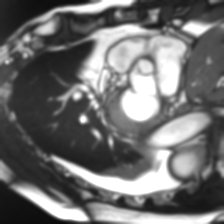

('patient001',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


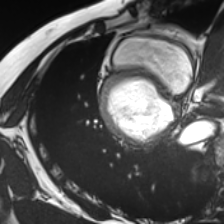

('patient002',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


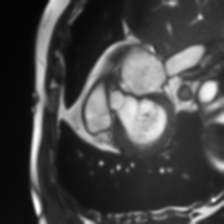

('patient003',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


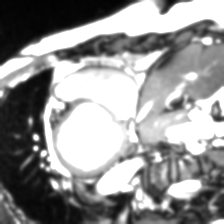

('patient004',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


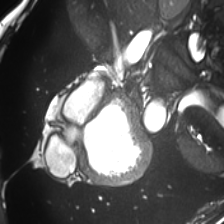

('patient005',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


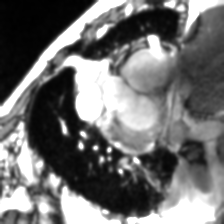

('patient006',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


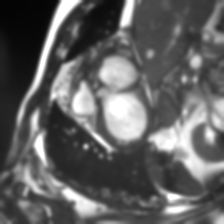

('patient007',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


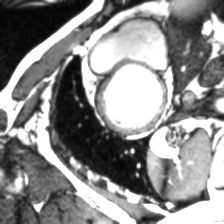

('patient008',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


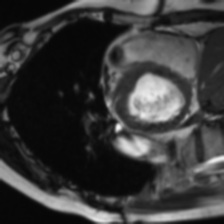

('patient009',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


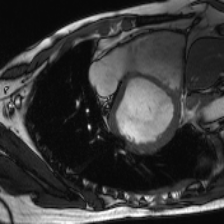

('patient010',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


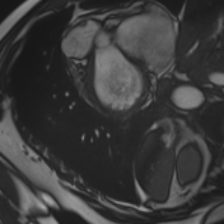

('patient011',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


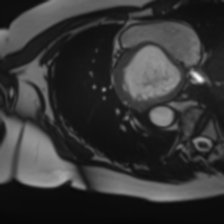

('patient012',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


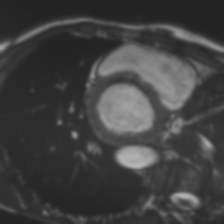

('patient013',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


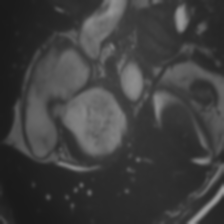

('patient014',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


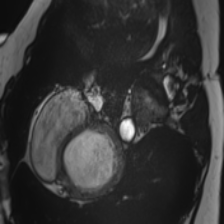

('patient015',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


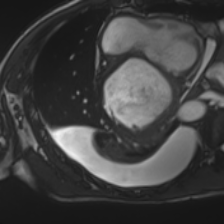

('patient016',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


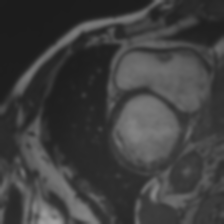

('patient017',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


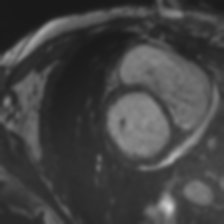

('patient018',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


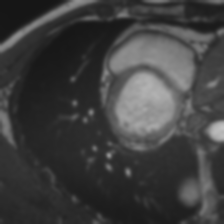

('patient019',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


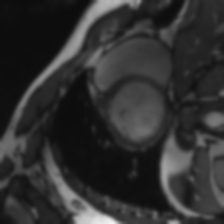

('patient020',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


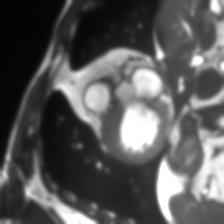

('patient021',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


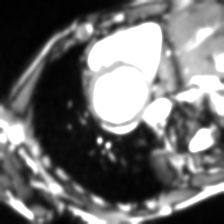

('patient022',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


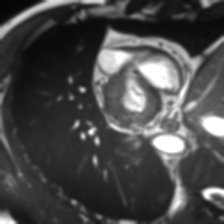

('patient023',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


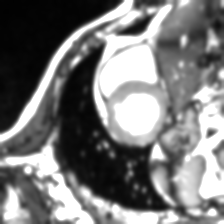

('patient024',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


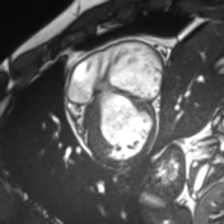

('patient025',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


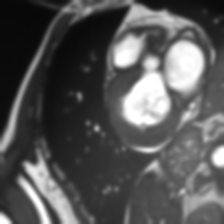

('patient026',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


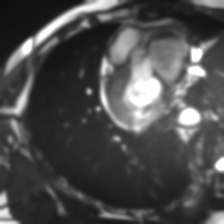

('patient027',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


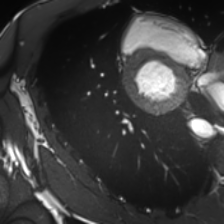

('patient028',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


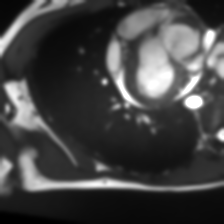

('patient029',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


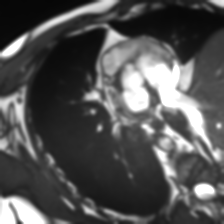

('patient030',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


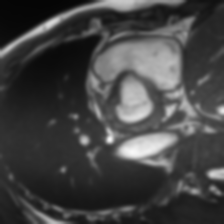

('patient031',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


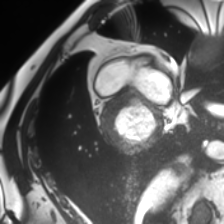

('patient032',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


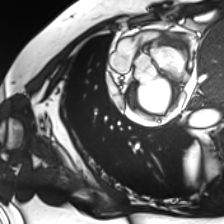

('patient033',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


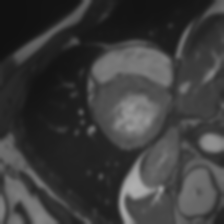

('patient034',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


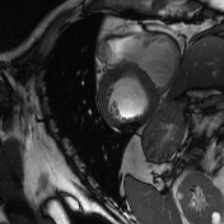

('patient035',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


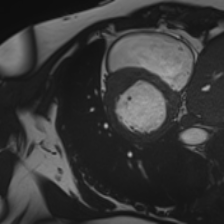

('patient036',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


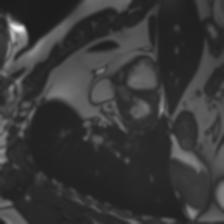

('patient037',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


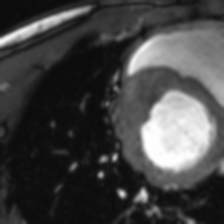

('patient038',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


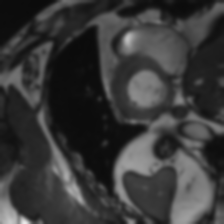

('patient039',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


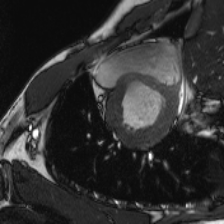

('patient040',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


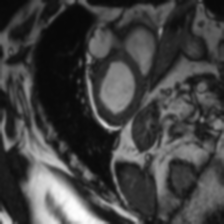

('patient041',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


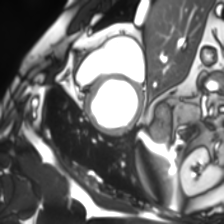

('patient042',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


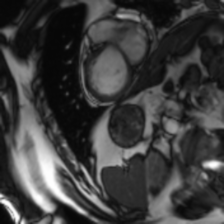

('patient043',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


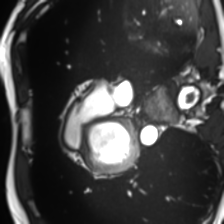

('patient044',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


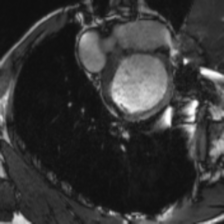

('patient045',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


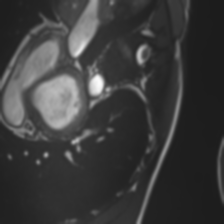

('patient046',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


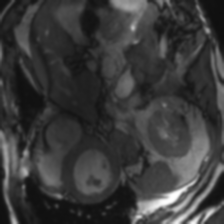

('patient047',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


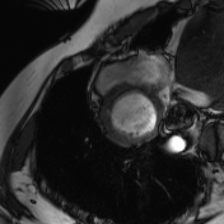

('patient048',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


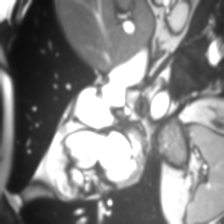

('patient049',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


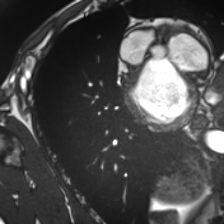

('patient050',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


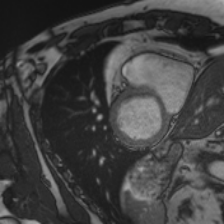

('patient051',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


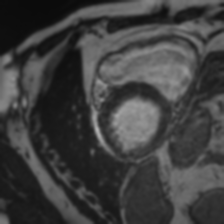

('patient052',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


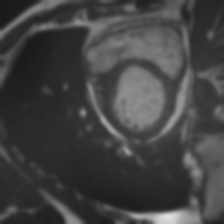

('patient053',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


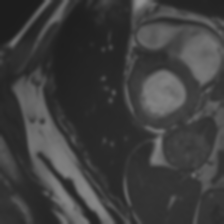

('patient054',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


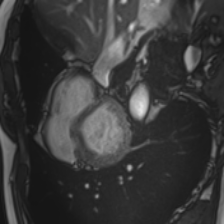

('patient055',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


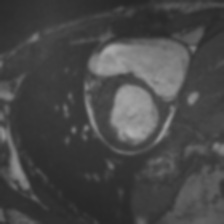

('patient056',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


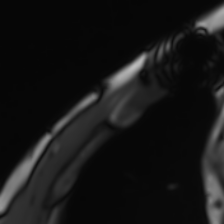

('patient057',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


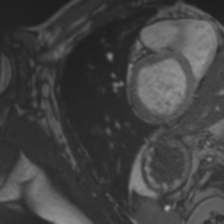

('patient058',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


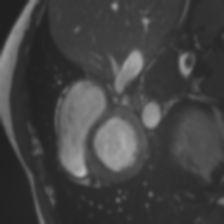

('patient059',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


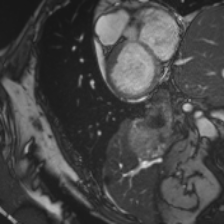

('patient060',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


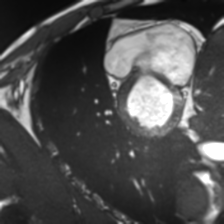

('patient061',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


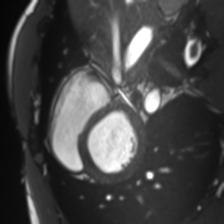

('patient062',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


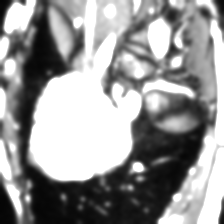

('patient063',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


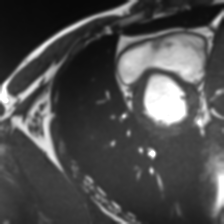

('patient064',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


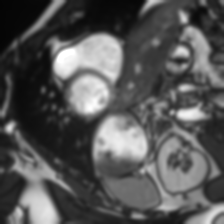

('patient065',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


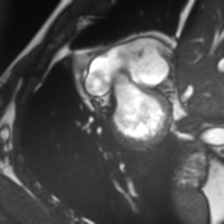

('patient066',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


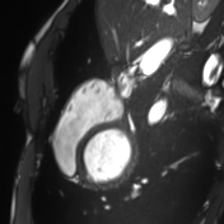

('patient067',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


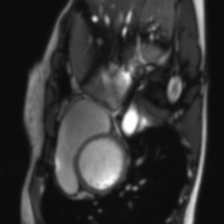

('patient068',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


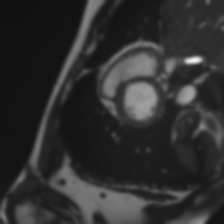

('patient069',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


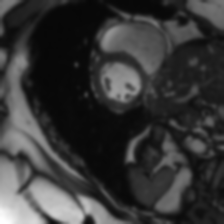

('patient070',)
--------------------------------------------------
70


In [ ]:
c = 0

for img, label, name in train_loader:
  c += 1
  print(img.shape)
  img = img.detach().cpu().numpy().squeeze()*255.
  cv2_imshow(img)
  # print(label)
  print(name)
  print('-'*50)

print(c) 

In [ ]:
for i, pack in enumerate(test_loader):
  # if i>0: continue
  print(pack.keys())
  img = pack['img'].detach().cpu().numpy().squeeze().transpose(1,2,0)*255.
  print(img.shape)
  cv2_imshow(img)
  # print(label)
#   print(name)
  print('-'*50)

Output hidden; open in https://colab.research.google.com to view.

torch.Size([1, 1, 224, 224])


<ipython-input-8-b9fa14eadb67>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(img_path).get_data()
<ipython-input-8-b9fa14eadb67>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nib.load(mask_path).get_data()


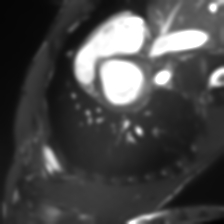

('patient071',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


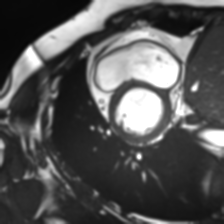

('patient072',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


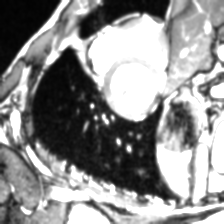

('patient073',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


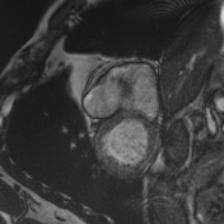

('patient074',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


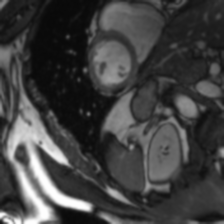

('patient075',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


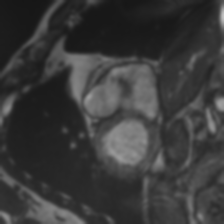

('patient076',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


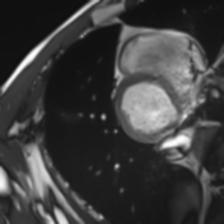

('patient077',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


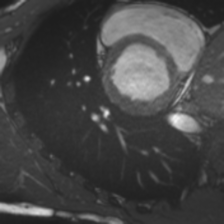

('patient078',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


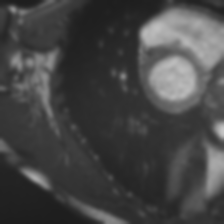

('patient079',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


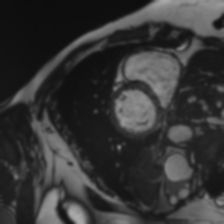

('patient080',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


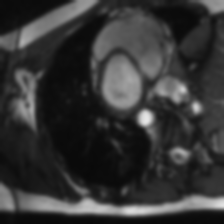

('patient081',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


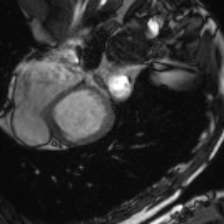

('patient082',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


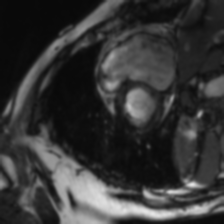

('patient083',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


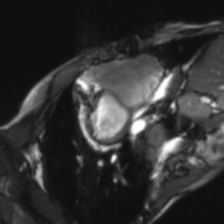

('patient084',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


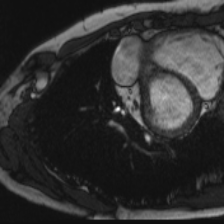

('patient085',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


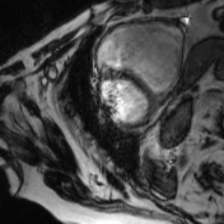

('patient086',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


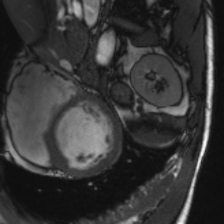

('patient087',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


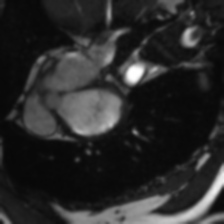

('patient088',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


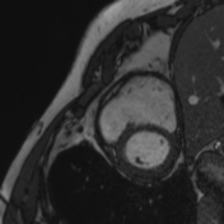

('patient089',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


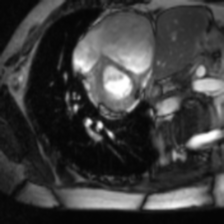

('patient090',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


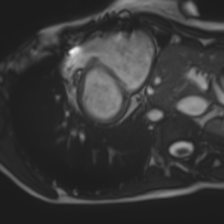

('patient091',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


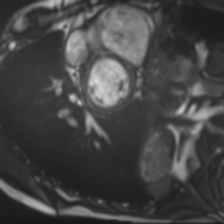

('patient092',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


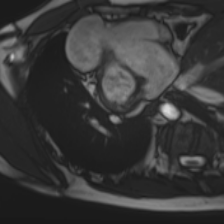

('patient093',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


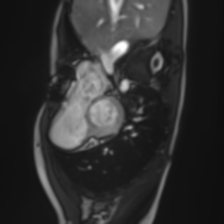

('patient094',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


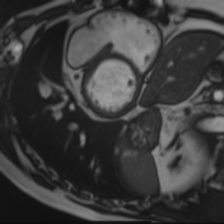

('patient095',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


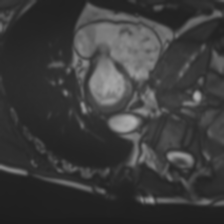

('patient096',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


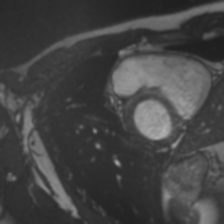

('patient097',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


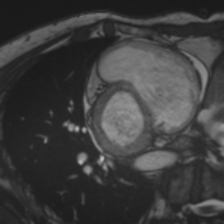

('patient098',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


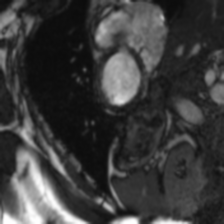

('patient099',)
--------------------------------------------------
torch.Size([1, 1, 224, 224])


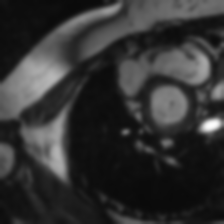

('patient100',)
--------------------------------------------------


In [ ]:
for i, (img, label, name) in enumerate(test_loader):
  # if i>0: continue
  print(img.shape)
  img = img.detach().cpu().numpy().squeeze()*255.
  cv2_imshow(img)
  # print(label)
  print(name)
  print('-'*50)

In [11]:
def convert(A, Ttnp = True):
    if Ttnp == True: return A.detach().cpu().numpy()
    else: return torch.tensor(A,device='cuda')

def disp_Tensor(map, scale=255.0):
    map = map.detach().cpu().numpy()
    if map.shape[1] == 3: cv2_imshow(map[0,:,:,:].transpose(1,2,0)*scale)
    elif map.shape[1] == 1: 
        map[map >= 0.5] = 1
        map[map < 0.5] = 0
        cv2_imshow(map[0,0,:,:]*scale)
    else:
        map = np.mean(map, axis=1)[0,:,:]*scale
        cv2_imshow(map)

Metrics

In [12]:
#Metrics: Batch-scaled
def vals(pred, mask):
    pred = torch.round(pred)
    # print(torch.max(mask))
    TP = (mask * pred).sum()
    TN = ((1 - mask) * (1 - pred)).sum()
    FP = pred.sum() - TP
    FN = mask.sum() - TP
    return TP,TN,FP,FN

def metrics(pred, mask): 
    pred = torch.sum(pred, dim=1)/torch.max(pred)
    mask = mask[:,0,:,:]
    TP,TN,FP,FN = vals(pred, mask)
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc = convert(torch.sum(acc))
    iou = (TP)/(TP + FN + FP)
    iou = convert(iou)
    # m_iou = monai.metrics.MeanIoU()
    # iou = np.mean(m_iou(pred, mask))
    sen = TP / (TP + FN)
    sen = convert(torch.sum(sen))
    prec = (TP)/ (TP + FP)
    prec = convert(torch.sum(prec))
    recc = TP / (TP + FN)
    recc = convert(torch.sum(recc))
    dice = (2*TP)/(2*TP+FP+FN)
    dice = convert(torch.sum(dice))
    metrics = {"acc": acc,
            "sen": sen,
            "pre": prec,
            "rec": recc,
            "dsc": dice,
            "iou": iou}
    return metrics

Loss function

In [13]:
#Loss function: H Loss :)
class loss_function(nn.Module):
    def __init__(self, batch=True):
        super(loss_function, self).__init__()
        self.batch = batch
        self.mae_loss = torch.nn.L1Loss()
        self.bce_loss = torch.nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        # score = (intersection + smooth) / (i + j - intersection + smooth)#iou
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def iou_loss(self, inputs, targets):
        smooth = 0.0
        #inputs = inputs.view(-1)
        #targets = targets.view(-1)
        
        intersection = (inputs * targets).sum(1).sum(1).sum(1)
        total = (inputs + targets).sum(1).sum(1).sum(1)
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return (1 - IoU.mean())

    def forward(self, y_true, y_pred):
        #a = self.mae_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        c = self.bce_loss(y_pred, y_true)
        d = self.iou_loss(y_pred, y_true)
        #loss = 0.05*a + 0.4*b + 0.15*c + 0.4*d
        loss = b + d + c
        return loss

In [15]:
DATAKEYS = ["loss", "acc", "sen", "pre", "rec", "dsc", "iou"]
def initiate_dict():
    dict = {}
    for k in DATAKEYS:
        dict[k] = 0.0
    return dict

class MyFrame():
    def __init__(self, net, learning_rate, device, evalmode=False):
      self.net = net.to(device)
      self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=learning_rate, weight_decay=0.0001)
      self.loss = loss_function().to(device)
      self.lr = learning_rate
      self.device = device
      if evalmode: self.net.eval()
    
    def set_input(self, img_batch, mask_batch=None):
        self.img = img_batch[:, :1, :, :]
        self.mask = mask_batch[:, :1, :, :]
        
    def propagate(self, backprop=True):
        p = self.net.forward(self.img)[:,:1,:,:]
        torch.backends.cudnn.benchmark = True
        loss = self.loss(self.mask, p)
        if backprop:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return convert(loss), p
    
    def run_epoch(self, loader, train=True):
        if train: self.net.train()
        else: self.net.eval()
        epoch_data = initiate_dict()
        L = len(loader)
        iterator = tqdm(enumerate(loader), total=L)
        for batch_idx, pack in iterator:
            img, map = pack["img"].to(self.device), pack["map"].to(self.device)
            self.set_input(img, map)
            if train: loss, pred = self.propagate()
            else: loss, pred = self.propagate(backprop=False)
            m = metrics(pred, map)
            epoch_data["loss"] += loss / L
            for k in list(m.keys()): epoch_data[k] += m[k] / L
        return epoch_data
        
    def save(self, path):
        torch.save(self.net.state_dict(), path)
        
    def load(self, path):
        self.net.load_state_dict(torch.load(path, map_location=self.device))

    def update_lr(self, new_lr, factor=False):
        if factor:
            new_lr = self.lr / new_lr
        #for param_group in self.net.param_groups:
        #    param_group['lr'] = new_lr
        self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=new_lr, weight_decay=0.0001)

        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        self.lr = new_lr


#Noise Train

##Train Unet

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/unet_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["unet"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

num img = 900
num map = 900
num img = 51
num map = 51


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


  0%|          | 0/900 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 900/900 [08:37<00:00,  1.74it/s]


Loss: 1.1535184075766152 , IOU: 0.7062177082091687
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:24<00:00,  2.06it/s]


Loss: 0.4153313809165768 , IOU: 0.8456496187650103
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:52<00:00, 17.19it/s]


Loss: 0.3032704202830793 , IOU: 0.8641688278772766
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 53.07it/s]


Loss: 0.2860651967280052 , IOU: 0.8564539894315544
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:52<00:00, 17.16it/s]


Loss: 0.2243635433332788 , IOU: 0.8846108827657179
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 51.97it/s]


Loss: 0.5420879081768147 , IOU: 0.7295492746611583
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:53<00:00, 16.81it/s]


Loss: 0.20746768580542674 , IOU: 0.8888033600813809
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 52.29it/s]


Loss: 0.2090290068995719 , IOU: 0.8843182693509495
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:52<00:00, 17.10it/s]


Loss: 0.1871675012012323 , IOU: 0.8981277677085666
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.61it/s]


Loss: 0.2135961583870299 , IOU: 0.8811771261925789
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:51<00:00, 17.57it/s]


Loss: 0.17426281387607231 , IOU: 0.9052409344746
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.09it/s]


Loss: 0.1918860104154138 , IOU: 0.8917370438575746
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.90it/s]


Loss: 0.17741094001879257 , IOU: 0.9025755344496834
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.92it/s]


Loss: 0.17089319893834637 , IOU: 0.9033640775026059
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.94it/s]


Loss: 0.15831525909403954 , IOU: 0.9129158261749476
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.01it/s]


Loss: 0.20778859494363555 , IOU: 0.8859625237026051
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:49<00:00, 18.35it/s]


Loss: 0.1505193698778749 , IOU: 0.9170374866988927
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.08it/s]


Loss: 0.20100465599520537 , IOU: 0.8890757128304126
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.74it/s]


Loss: 0.15077742825779622 , IOU: 0.9174907103843166
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:00<00:00, 51.10it/s]


Loss: 0.20214715950629297 , IOU: 0.8896938340336669
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:51<00:00, 17.46it/s]


Loss: 0.1577969915875132 , IOU: 0.9137536392940405
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.05it/s]


Loss: 0.18062037894246624 , IOU: 0.8975858407862045
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:51<00:00, 17.63it/s]


Loss: 0.14994046660761062 , IOU: 0.9182135018706333
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.40it/s]


Loss: 0.26668889250825434 , IOU: 0.8563607370152193
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.83it/s]


Loss: 0.17022376979804696 , IOU: 0.9083833196924797
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:00<00:00, 53.00it/s]


Loss: 0.3734879070783363 , IOU: 0.8034647266270923
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.84it/s]


Loss: 0.14524158382167415 , IOU: 0.9200834872170047
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.17it/s]


Loss: 0.3935298099383418 , IOU: 0.796446991536547
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.92it/s]


Loss: 0.13814808823168287 , IOU: 0.92314891603258
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.70it/s]


Loss: 0.5480203950668083 , IOU: 0.7357580560880402
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:49<00:00, 18.06it/s]


Loss: 0.1400139404502179 , IOU: 0.9234684781440428
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.58it/s]


Loss: 0.3901342445728826 , IOU: 0.7940119243427817
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.96it/s]


Loss: 0.14907782380365667 , IOU: 0.9185972335686292
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 42.41it/s]


Loss: 0.41875063467259505 , IOU: 0.7855566508301041
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:49<00:00, 18.07it/s]


Loss: 0.1287854133091039 , IOU: 0.9292135147915939
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.49it/s]


Loss: 0.25419228808844785 , IOU: 0.8631062316982185
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.95it/s]


Loss: 0.1248158312754497 , IOU: 0.930624331699479
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.66it/s]


Loss: 0.21299949777769112 , IOU: 0.8836392397974056
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:50<00:00, 17.90it/s]


Loss: 0.1326948411928284 , IOU: 0.926623127547403
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.70it/s]

Loss: 0.22235080599784848 , IOU: 0.8780641798295228
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.9033640775026059


In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/upp_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["upp"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

num img = 900
num map = 900
num img = 51
num map = 51
--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


  0%|          | 0/900 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 900/900 [00:59<00:00, 15.02it/s]


Loss: 1.3102599721650272 , IOU: 0.6995601185254701
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.88it/s]


Loss: 0.417262399021317 , IOU: 0.8501576991642222
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.35it/s]


Loss: 0.29531912245684155 , IOU: 0.8687190738610102
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.40it/s]


Loss: 0.23086554323341335 , IOU: 0.8822324895391278
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:59<00:00, 15.02it/s]


Loss: 0.23086444080703783 , IOU: 0.8815386417632302
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.80it/s]


Loss: 0.2039602731957155 , IOU: 0.8891818932458468
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:59<00:00, 15.24it/s]


Loss: 0.18977328121248208 , IOU: 0.8988923362435551
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:01<00:00, 37.57it/s]


Loss: 0.18168113629023236 , IOU: 0.899867620538263
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.43it/s]


Loss: 0.17066091967125718 , IOU: 0.9073014450073239
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.85it/s]


Loss: 0.18890210489432016 , IOU: 0.8947187513113023
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.43it/s]


Loss: 0.15820967041783857 , IOU: 0.9135031389527858
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:01<00:00, 36.27it/s]


Loss: 0.2125823999590733 , IOU: 0.8817093290534672
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.44it/s]


Loss: 0.18523535773158065 , IOU: 0.8990575101474935
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.93it/s]


Loss: 0.19056289657658226 , IOU: 0.8919407117600537
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.29it/s]


Loss: 0.15997269154422838 , IOU: 0.9123905461695456
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:01<00:00, 37.54it/s]


Loss: 0.16204448183085407 , IOU: 0.9075932374187548
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.46it/s]


Loss: 0.1416428146925236 , IOU: 0.9222835568586991
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.47it/s]


Loss: 0.23347174704951398 , IOU: 0.8746877336034588
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.35it/s]


Loss: 0.14004218569646265 , IOU: 0.9228904973136044
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.18it/s]


Loss: 0.16186727919414928 , IOU: 0.907704315933527
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.43it/s]


Loss: 0.15493499976893266 , IOU: 0.916217351357142
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.16it/s]


Loss: 0.25207486902089676 , IOU: 0.8625938059652555
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:59<00:00, 15.24it/s]


Loss: 0.1351048361468646 , IOU: 0.9248979045285115
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.13it/s]


Loss: 0.3616482288960149 , IOU: 0.8126239408830218
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.48it/s]


Loss: 0.14214864569819646 , IOU: 0.922107036279307
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.09it/s]


Loss: 0.2210913202634045 , IOU: 0.8778794343565024
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.35it/s]


Loss: 0.12581483204745572 , IOU: 0.9305645703607137
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.50it/s]


Loss: 0.18957022168472704 , IOU: 0.8958021893586016
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.36it/s]


Loss: 0.12366708414422146 , IOU: 0.9319895430737072
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.96it/s]


Loss: 0.1829469704306593 , IOU: 0.8994990119747086
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:59<00:00, 15.06it/s]


Loss: 0.1394601380949218 , IOU: 0.9238764326491694
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.90it/s]


Loss: 0.3763700037025939 , IOU: 0.8089470182015908
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:57<00:00, 15.53it/s]


Loss: 0.137933996597098 , IOU: 0.925290518618293
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.11it/s]


Loss: 0.19398614720386623 , IOU: 0.8926453789075217
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:59<00:00, 15.23it/s]


Loss: 0.11945284994939977 , IOU: 0.9350195973449299
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.10it/s]


Loss: 0.19868190820310633 , IOU: 0.891671566402211
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.44it/s]


Loss: 0.11379658941179503 , IOU: 0.9376561454931903
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.87it/s]


Loss: 0.2174664073276754 , IOU: 0.8825266396298129
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:58<00:00, 15.27it/s]


Loss: 0.11149652140835915 , IOU: 0.9385319432947373
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.39it/s]

Loss: 0.22093339783011692 , IOU: 0.8811166409183951
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.907704315933527


In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/fpn_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["fpn"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/psp_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["psp"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

num img = 900
num map = 900
num img = 51
num map = 51
--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


  0%|          | 0/900 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 900/900 [00:30<00:00, 29.59it/s]


Loss: 0.5160124154306114 , IOU: 0.7574529585297896
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.84it/s]


Loss: 0.34101102705679687 , IOU: 0.8106010439349157
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.73it/s]


Loss: 0.2825099333789616 , IOU: 0.8490288482854764
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 65.00it/s]


Loss: 0.3307186026199191 , IOU: 0.8094473329244875
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.66it/s]


Loss: 0.23055869165394036 , IOU: 0.8740581606328487
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.30it/s]


Loss: 0.27990530811104125 , IOU: 0.8390723268191019
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.53it/s]


Loss: 0.21485293313033046 , IOU: 0.8820578604439893
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 78.40it/s]


Loss: 0.2582019872086889 , IOU: 0.8565874137714796
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.51it/s]


Loss: 0.19673075273632973 , IOU: 0.8914908007449583
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:00<00:00, 61.57it/s]


Loss: 0.40046803361060573 , IOU: 0.7717939979013274
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.90it/s]


Loss: 0.19183250458704118 , IOU: 0.894600868516913
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.14it/s]


Loss: 0.2188707784402604 , IOU: 0.8768228707360287
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.92it/s]


Loss: 0.17465752130995196 , IOU: 0.903219959201911
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.18it/s]


Loss: 0.2005736284396228 , IOU: 0.8861091768040374
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.66it/s]


Loss: 0.16641199385540337 , IOU: 0.9070783791277153
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:00<00:00, 64.23it/s]


Loss: 0.23216340311017689 , IOU: 0.8681230360970779
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.48it/s]


Loss: 0.17371041965567408 , IOU: 0.9044041452360245
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.75it/s]


Loss: 0.20286536318998716 , IOU: 0.8853420036680559
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.61it/s]


Loss: 0.1584057825141485 , IOU: 0.911925515102015
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.88it/s]


Loss: 0.2232191713125098 , IOU: 0.877650180886335
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.11it/s]


Loss: 0.1534377375617624 , IOU: 0.9141956179671822
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:00<00:00, 66.14it/s]


Loss: 0.2018750112722902 , IOU: 0.8853022131849738
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.13it/s]


Loss: 0.15112114129381057 , IOU: 0.9153929972317475
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 75.60it/s]


Loss: 0.1856665184684828 , IOU: 0.8938504258791606
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.18it/s]


Loss: 0.1461972329227461 , IOU: 0.9177841810385391
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.26it/s]


Loss: 0.1896368279760959 , IOU: 0.8932321971538019
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.07it/s]


Loss: 0.14416352288176615 , IOU: 0.9192113444540236
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:00<00:00, 65.32it/s]


Loss: 0.1862957669677687 , IOU: 0.8943558300242705
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.82it/s]


Loss: 0.13794951008839737 , IOU: 0.9222423761420774
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:00<00:00, 68.03it/s]


Loss: 0.19487340456130461 , IOU: 0.8886764271586549
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.75it/s]


Loss: 0.13507309830023184 , IOU: 0.923616772095364
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:00<00:00, 71.82it/s]


Loss: 0.2190032641531206 , IOU: 0.8780376765073516
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.36it/s]


Loss: 0.13322397211359613 , IOU: 0.9246024689740604
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:00<00:00, 59.54it/s]


Loss: 0.17244534888396074 , IOU: 0.9029244219555574
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:30<00:00, 29.77it/s]


Loss: 0.13111040033400073 , IOU: 0.9256630881627397
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:00<00:00, 73.67it/s]


Loss: 0.17976568909544569 , IOU: 0.8985311435718162
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.55it/s]


Loss: 0.1300224550813436 , IOU: 0.9264908720387359
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:00<00:00, 71.64it/s]


Loss: 0.1777834423324641 , IOU: 0.899511098861694
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:29<00:00, 30.58it/s]


Loss: 0.1284867980248399 , IOU: 0.9275228656993968
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 70.04it/s]

Loss: 0.185976847567979 , IOU: 0.8960368306029075
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.9029244219555574


In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/link_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["link"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/man_noise.pth'
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

train_dataset = Segmentation_Dataset(root_path, split="train", noise="train")
test_dataset = Segmentation_Dataset(root_path, split="test")

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

model = get_model(model_dict["man"]["model"])
frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)  

num img = 900
num map = 900
num img = 51
num map = 51
--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


  0%|          | 0/900 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 900/900 [01:03<00:00, 14.20it/s]


Loss: 1.0122635356419611 , IOU: 0.6788030213929923
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.67it/s]


Loss: 0.4693617525638318 , IOU: 0.7954961179810413
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.11it/s]


Loss: 0.3097461233950326 , IOU: 0.8542589778711827
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.51it/s]


Loss: 0.3015456881885435 , IOU: 0.8432626579614249
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.26it/s]


Loss: 0.22247222716609677 , IOU: 0.8851228151387626
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.93it/s]


Loss: 0.24389156655353655 , IOU: 0.8646509086384492
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.22it/s]


Loss: 0.20812205009162435 , IOU: 0.8887532172675451
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.90it/s]


Loss: 0.2328748381605336 , IOU: 0.872384274707121
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.25it/s]


Loss: 0.2061402640781466 , IOU: 0.8890697706739108
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.69it/s]


Loss: 0.3353237877873815 , IOU: 0.8239453693157902
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.30it/s]


Loss: 0.18919086672365654 , IOU: 0.8979378719462279
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.34it/s]


Loss: 0.16820965838782928 , IOU: 0.9051267866994823
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.26it/s]


Loss: 0.17029830881290983 , IOU: 0.9065682340992824
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.28it/s]


Loss: 0.1969220924611185 , IOU: 0.88842656156596
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.58it/s]


Loss: 0.16468267902731895 , IOU: 0.9093194482061588
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.28it/s]


Loss: 0.3755942792722992 , IOU: 0.800089900600998
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.45it/s]


Loss: 0.16709862719393406 , IOU: 0.9083765502439596
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.73it/s]


Loss: 0.16417279912560595 , IOU: 0.9078627567665252
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.21it/s]


Loss: 0.16648730151769178 , IOU: 0.9086738995379876
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.39it/s]


Loss: 0.21779458348949743 , IOU: 0.880006568688972
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.16it/s]


Loss: 0.17610041526870598 , IOU: 0.9039059483342711
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.27it/s]


Loss: 0.7731559893810283 , IOU: 0.6260268860907456
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.17it/s]


Loss: 0.1558729378175407 , IOU: 0.9144653926624174
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.52it/s]


Loss: 0.3274554725663336 , IOU: 0.8342856048040238
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.21it/s]


Loss: 0.14340633778108489 , IOU: 0.9210837811231614
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.28it/s]


Loss: 0.3461203251545336 , IOU: 0.819050798576106
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.18it/s]


Loss: 0.14032931189156234 , IOU: 0.9223500335216521
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.66it/s]


Loss: 0.2665310846824272 , IOU: 0.8568079550476632
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.26it/s]


Loss: 0.13696335600068169 , IOU: 0.9242902184194982
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.13it/s]


Loss: 0.26286278898809473 , IOU: 0.8620707233454666
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [01:03<00:00, 14.24it/s]


Loss: 0.13795288508964915 , IOU: 0.9238739987214416
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.03it/s]


Loss: 0.28058342854766277 , IOU: 0.8532076917734802
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.30it/s]


Loss: 0.1521549751816525 , IOU: 0.9174241715504069
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 36.32it/s]


Loss: 0.5261970136095496 , IOU: 0.7322960271198738
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.40it/s]


Loss: 0.1438004903288353 , IOU: 0.9206021495991278
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.31it/s]


Loss: 0.2189791691215599 , IOU: 0.8801304779800715
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.35it/s]


Loss: 0.15355021232532123 , IOU: 0.9167847323190008
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.87it/s]


Loss: 0.293972764383344 , IOU: 0.8470909169135504
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.29it/s]


Loss: 0.1477428766050273 , IOU: 0.9193243039254512
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.52it/s]

Loss: 0.8399869999757004 , IOU: 0.5951111108959452
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.9078627567665252


#Noise Tests

In [8]:
model_dict = {
    "unet": {"model": smp.Unet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/unet.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/unet_noise.pth"},
    "upp": {"model": smp.UnetPlusPlus, "weights": "/content/drive/MyDrive/AC_foreground/Weights/unet_plus_plus.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/upp_noise.pth"},
    "fpn": {"model": smp.FPN, "weights": "/content/drive/MyDrive/AC_foreground/Weights/fpn_g.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/fpn_noise.pth"},
    "psp": {"model": smp.PSPNet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/PSPNet.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/psp_noise.pth"},
    "man": {"model": smp.MAnet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/MANet.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/man_noise.pth"},
    "link": {"model": smp.Linknet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/LinkNet.pth", "noise": "/content/drive/MyDrive/AC_foreground/Weights/link_noise.pth"}
}

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

def get_model(MODEL):
    model = MODEL(
        encoder_name="resnet34",        
        encoder_weights="imagenet",     
        activation='sigmoid',
        in_channels=1,                  
        classes=1,                      
    )
    return model

In [ ]:
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

noises = ["gauss", "s&p", "speckle", "poisson"]
levels = [0, 1, 2]

#test_dataset = Segmentation_Dataset(root_path, split="test")
#test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

for run in list(model_dict.keys()):
    model = get_model(model_dict[run]["model"])
    for noise in noises:
        if noise in ["gauss", "s&p"]:
            for level in levels:
                print("===============>", run, noise, level)
                test_dataset = Segmentation_Dataset(root_path, split="test", noise=noise, level=level)
                test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
                frame = MyFrame(model, 1, device, evalmode=True)
                frame.load(model_dict[run]["weights"])
                te_dict = frame.run_epoch(test_loader, train=False)
                print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
        else:
            print("===============>", run, noise)
            test_dataset = Segmentation_Dataset(root_path, split="test", noise=noise)
            test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
            frame = MyFrame(model, 1, device, evalmode=True)
            frame.load(model_dict[run]["weights"])
            te_dict = frame.run_epoch(test_loader, train=False)
            print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])

===============> unet gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:04<00:00, 11.29it/s]


Loss: 0.190851995611892 , IOU: 0.8931939276117906
===============> unet gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.95it/s]


Loss: 0.18700621627709443 , IOU: 0.8946508578225678
===============> unet gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 40.52it/s]


Loss: 0.18799593986249438 , IOU: 0.8943450681719126
===============> unet s&p 0
num img = 51
num map = 51


  0%|          | 0/51 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 51/51 [00:00<00:00, 52.41it/s]


Loss: 0.5352828106751629 , IOU: 0.7306598765118157
===============> unet s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 53.03it/s]


Loss: 0.4528108180737963 , IOU: 0.7711404422480685
===============> unet s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 45.17it/s]


Loss: 0.5420239652488746 , IOU: 0.7255131530201098
===============> unet speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 35.14it/s]


Loss: 2.2857398379082787 , IOU: 0.00021087615659423907
===============> unet poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 25.51it/s]


Loss: 0.18571712712154673 , IOU: 0.8954568829606562
===============> upp gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 35.39it/s]


Loss: 0.2256531112772577 , IOU: 0.8774183594859115
===============> upp gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 32.27it/s]


Loss: 0.22610262299285216 , IOU: 0.8766733372912688
===============> upp gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.78it/s]


Loss: 0.2250613363496229 , IOU: 0.8773277590379992
===============> upp s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 35.93it/s]


Loss: 0.2625306429085778 , IOU: 0.8572327155692905
===============> upp s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 45.82it/s]


Loss: 0.24223612891692745 , IOU: 0.8679636261042426
===============> upp s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 39.66it/s]


Loss: 0.25422862405870483 , IOU: 0.8612801794912303
===============> upp speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 40.08it/s]


Loss: 2.2269048083062266 , IOU: 0.0
===============> upp poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 25.92it/s]


Loss: 0.2253391097719763 , IOU: 0.8767003159897001
===============> fpn gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 37.71it/s]


Loss: 0.17330734387916674 , IOU: 0.9024439904035304
===============> fpn gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 42.41it/s]


Loss: 0.1730121171065405 , IOU: 0.9022394541431877
===============> fpn gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 41.88it/s]


Loss: 0.17375617467013063 , IOU: 0.9019395007806666
===============> fpn s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 52.51it/s]


Loss: 0.3204932329701442 , IOU: 0.83123113711675
===============> fpn s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 52.61it/s]


Loss: 0.2820790069652539 , IOU: 0.8470101946709204
===============> fpn s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 49.81it/s]


Loss: 0.31328536248674577 , IOU: 0.8321164357019406
===============> fpn speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 35.64it/s]


Loss: 2.6243590654111384 , IOU: 0.0
===============> fpn poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 26.06it/s]


Loss: 0.17252577497970822 , IOU: 0.9026408435082902
===============> psp gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 54.05it/s]


Loss: 0.20210439857898976 , IOU: 0.8893397146580266
===============> psp gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 58.04it/s]


Loss: 0.2027466656530605 , IOU: 0.8895092833714157
===============> psp gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 55.76it/s]


Loss: 0.20215094724998753 , IOU: 0.8891445199648539
===============> psp s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 61.05it/s]


Loss: 0.27775131589641755 , IOU: 0.8470915883195166
===============> psp s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 61.74it/s]


Loss: 0.28635541174341655 , IOU: 0.842299494673224
===============> psp s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 73.42it/s]


Loss: 0.2898503502502161 , IOU: 0.8402219040721068
===============> psp speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 59.15it/s]


Loss: 3.56968381358128 , IOU: 0.0
===============> psp poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 36.32it/s]


Loss: 0.20195114970499395 , IOU: 0.8893500811913436
===============> man gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.77it/s]


Loss: 0.19948421652410547 , IOU: 0.8930220761719873
===============> man gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 27.97it/s]


Loss: 0.20173729707797364 , IOU: 0.8924222204322909
===============> man gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 36.87it/s]


Loss: 0.20317188431234925 , IOU: 0.8924045070421458
===============> man s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 44.82it/s]


Loss: 0.3354636350390958 , IOU: 0.824721960898708
===============> man s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 44.72it/s]


Loss: 0.3749511332488526 , IOU: 0.8042202770125633
===============> man s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 38.33it/s]


Loss: 0.34742219220189485 , IOU: 0.8189955756944769
===============> man speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 29.67it/s]


Loss: 2.23710647283816 , IOU: 2.195727189674097e-05
===============> man poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:02<00:00, 22.32it/s]


Loss: 0.20364501385712153 , IOU: 0.8919007531275934
===============> link gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.02it/s]


Loss: 0.20354251490504127 , IOU: 0.8869227685180363
===============> link gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 42.79it/s]


Loss: 0.20349651750396283 , IOU: 0.8868530807541866
===============> link gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 35.28it/s]


Loss: 0.20050646423124804 , IOU: 0.8886845167361052
===============> link s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.17it/s]


Loss: 0.41800452798020615 , IOU: 0.7772533122938599
===============> link s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 48.80it/s]


Loss: 0.3753985042373338 , IOU: 0.7996696997799128
===============> link s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 51.58it/s]


Loss: 0.36846968663089413 , IOU: 0.8020695463991633
===============> link speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 40.78it/s]


Loss: 2.2672776053933537 , IOU: 0.0002321370480143849
===============> link poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:02<00:00, 22.11it/s]

Loss: 0.19962417232055296 , IOU: 0.888515743554807


In [ ]:
root_path = '/content/drive/MyDrive/Real_ACDC/data_2d'

noises = ["gauss", "s&p", "speckle", "poisson"]
levels = [0, 1, 2]

#test_dataset = Segmentation_Dataset(root_path, split="test")
#test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

for run in list(model_dict.keys()):
    model = get_model(model_dict[run]["model"])
    for noise in noises:
        if noise in ["gauss", "s&p"]:
            for level in levels:
                print("===============>", run, noise, level)
                test_dataset = Segmentation_Dataset(root_path, split="test", noise=noise, level=level)
                test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
                frame = MyFrame(model, 1, device, evalmode=True)
                frame.load(model_dict[run]["noise"])
                te_dict = frame.run_epoch(test_loader, train=False)
                print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
        else:
            print("===============>", run, noise)
            test_dataset = Segmentation_Dataset(root_path, split="test", noise=noise)
            test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
            frame = MyFrame(model, 1, device, evalmode=True)
            frame.load(model_dict[run]["noise"])
            te_dict = frame.run_epoch(test_loader, train=False)
            print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])

===============> unet gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 36.14it/s]


Loss: 0.1703774216128331 , IOU: 0.9037297484921473
===============> unet gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 34.27it/s]


Loss: 0.17403180283658648 , IOU: 0.9013102276652468
===============> unet gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 36.37it/s]


Loss: 0.16981900424933902 , IOU: 0.9036045927627416
===============> unet s&p 0
num img = 51
num map = 51


  0%|          | 0/51 [00:00<?, ?it/s]<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0
100%|██████████| 51/51 [00:00<00:00, 53.26it/s]


Loss: 0.17874717252219424 , IOU: 0.8986607006951876
===============> unet s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 54.19it/s]


Loss: 0.17767558801992264 , IOU: 0.8989779984249789
===============> unet s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 52.98it/s]


Loss: 0.17421783945139713 , IOU: 0.9011359904326642
===============> unet speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 45.00it/s]


Loss: 2.285580452750711 , IOU: 0.00012823770407075977
===============> unet poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 27.91it/s]


Loss: 0.171844576722851 , IOU: 0.902638378096562
===============> upp gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.62it/s]


Loss: 0.16183286554673137 , IOU: 0.9074301684603974
===============> upp gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 37.02it/s]


Loss: 0.1618543575499572 , IOU: 0.9075949051800895
===============> upp gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 39.19it/s]


Loss: 0.16194928605474673 , IOU: 0.907667299111684
===============> upp s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 42.13it/s]


Loss: 0.16258103064462254 , IOU: 0.9075259870173885
===============> upp s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 47.03it/s]


Loss: 0.16807103653748828 , IOU: 0.9043456351055822
===============> upp s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 41.42it/s]


Loss: 0.16529756404605567 , IOU: 0.9060744222472695
===============> upp speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 30.50it/s]


Loss: 2.3228670195037244 , IOU: 0.0
===============> upp poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 27.02it/s]


Loss: 0.1617964702640094 , IOU: 0.9080113008910533
===============> fpn gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 41.22it/s]


Loss: 0.1802130432835981 , IOU: 0.8985181836520924
===============> fpn gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 41.50it/s]


Loss: 0.18062456273565106 , IOU: 0.8981542330162198
===============> fpn gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.00it/s]


Loss: 0.18010225797108576 , IOU: 0.898331295041477
===============> fpn s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 48.55it/s]


Loss: 0.18932401052877018 , IOU: 0.8932647728452496
===============> fpn s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 44.56it/s]


Loss: 0.18706951714029496 , IOU: 0.8945020647609931
===============> fpn s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 42.58it/s]


Loss: 0.19196335730307243 , IOU: 0.8914525041393204
===============> fpn speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 42.87it/s]


Loss: 2.5390457919999667 , IOU: 0.00027199024699774447
===============> fpn poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 30.92it/s]


Loss: 0.18077041968411087 , IOU: 0.898314920126223
===============> psp gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 58.97it/s]


Loss: 0.17318678720324654 , IOU: 0.9025930435049767
===============> psp gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 57.57it/s]


Loss: 0.17297725876172387 , IOU: 0.9025508001738906
===============> psp gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 56.86it/s]


Loss: 0.17286054198356238 , IOU: 0.9027458721516178
===============> psp s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 62.19it/s]


Loss: 0.18639859250363178 , IOU: 0.8945451741125069
===============> psp s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 65.93it/s]


Loss: 0.18580257205986508 , IOU: 0.894062340259552
===============> psp s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 73.47it/s]


Loss: 0.18231828569197187 , IOU: 0.8972403559030271
===============> psp speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 55.83it/s]


Loss: 2.6336199536043057 , IOU: 0.0
===============> psp poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 38.73it/s]


Loss: 0.17252757283402423 , IOU: 0.9029730511646643
===============> man gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 37.49it/s]


Loss: 0.16420774074161756 , IOU: 0.9078430030860152
===============> man gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 38.51it/s]


Loss: 0.16491834132694733 , IOU: 0.9079004701446082
===============> man gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.55it/s]


Loss: 0.16687681613599553 , IOU: 0.9064839809548622
===============> man s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 36.64it/s]


Loss: 0.1717014061469658 , IOU: 0.9030214501362218
===============> man s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.90it/s]


Loss: 0.21651104443213517 , IOU: 0.8797671672175912
===============> man s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 44.47it/s]


Loss: 0.19177417084574697 , IOU: 0.8916887453958104
===============> man speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 39.08it/s]


Loss: 2.296588710710114 , IOU: 0.00037271876627688897
===============> man poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 28.11it/s]


Loss: 0.16484619720893748 , IOU: 0.9078098558912091
===============> link gauss 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 26.29it/s]


Loss: 0.18895968838649638 , IOU: 0.8964582144045361
===============> link gauss 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 39.97it/s]


Loss: 0.18968227491074918 , IOU: 0.8959898843484767
===============> link gauss 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.78it/s]


Loss: 0.19001385569572452 , IOU: 0.8958212429401924
===============> link s&p 0
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 49.69it/s]


Loss: 0.21754253918633742 , IOU: 0.8816323151775434
===============> link s&p 1
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 53.81it/s]


Loss: 0.21162925222340756 , IOU: 0.8849847643983133
===============> link s&p 2
num img = 51
num map = 51


100%|██████████| 51/51 [00:00<00:00, 55.72it/s]


Loss: 0.2127085185664542 , IOU: 0.883557780116212
===============> link speckle
num img = 51
num map = 51


100%|██████████| 51/51 [00:01<00:00, 43.76it/s]


Loss: 2.3013138116574754 , IOU: 0.0
===============> link poisson
num img = 51
num map = 51


100%|██████████| 51/51 [00:02<00:00, 23.99it/s]

Loss: 0.18984131420067712 , IOU: 0.8960362415687712


#Old

Train Unet

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/unet.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)    

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.02it/s]


Loss: 1.1469695237610078 , IOU: 0.710875853452857
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:00<00:00, 52.53it/s]


Loss: 0.5032512583568985 , IOU: 0.7965251826772501
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.00it/s]


Loss: 0.3022054240521451 , IOU: 0.8710810769100984
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.30it/s]


Loss: 0.2734140416278559 , IOU: 0.8650395618934257
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.64it/s]


Loss: 0.2100134244271451 , IOU: 0.8952331436508235
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 58.20it/s]


Loss: 0.24532968930754012 , IOU: 0.8679512029185015
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.14it/s]


Loss: 0.22101727094915177 , IOU: 0.8851862568656617
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.95it/s]


Loss: 0.26588410153692843 , IOU: 0.8587733388823622
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.67it/s]


Loss: 0.17168396853738327 , IOU: 0.9081868273185361
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.41it/s]


Loss: 0.28133890135031125 , IOU: 0.8522962396781816
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.78it/s]


Loss: 0.16099675333334335 , IOU: 0.9128674698124337
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.96it/s]


Loss: 0.22718104515589924 , IOU: 0.8760308395413792
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.42it/s]


Loss: 0.15070950823525595 , IOU: 0.9183420422838785
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:00<00:00, 58.37it/s]


Loss: 0.19050980322793418 , IOU: 0.8934964466036536
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.53it/s]


Loss: 0.15234991116242275 , IOU: 0.9170966954363727
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.26it/s]


Loss: 0.22870275874932608 , IOU: 0.8743864506044808
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.41it/s]


Loss: 0.14538022225515684 , IOU: 0.9199375839696997
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.92it/s]


Loss: 0.19902446763772588 , IOU: 0.8903709696788413
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.81it/s]


Loss: 0.14537924982193443 , IOU: 0.9199894265457983
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.58it/s]


Loss: 0.2847766778340527 , IOU: 0.8445751471262354
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.78it/s]


Loss: 0.13334211676898927 , IOU: 0.9261964971489366
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.62it/s]


Loss: 0.20860550844786213 , IOU: 0.8862711440260503
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.54it/s]


Loss: 0.12738227301173732 , IOU: 0.9293201741907322
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.17it/s]


Loss: 0.2839456356915773 , IOU: 0.8487421542990442
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.70it/s]


Loss: 0.13378038438657933 , IOU: 0.9260693120128582
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.68it/s]


Loss: 0.7110928794478666 , IOU: 0.6608072393573822
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.50it/s]


Loss: 0.12466290106789922 , IOU: 0.9305193345414269
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.97it/s]


Loss: 0.4893313798249937 , IOU: 0.755674608051777
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.58it/s]


Loss: 0.11913933282097185 , IOU: 0.9336582786507077
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:00<00:00, 58.48it/s]


Loss: 0.30919351618663937 , IOU: 0.8392040556406275
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.82it/s]


Loss: 0.11587354864511229 , IOU: 0.9352806247605225
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.11it/s]


Loss: 0.26248484908365743 , IOU: 0.8597430008299214
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.32it/s]


Loss: 0.11490196021066759 , IOU: 0.9355506753921522
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.44it/s]


Loss: 0.2332510038041601 , IOU: 0.8730083455642064
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:51<00:00, 17.48it/s]


Loss: 0.12141233809706245 , IOU: 0.9327519779735145
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.47it/s]


Loss: 0.24713733916481334 , IOU: 0.8672302736371171
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.60it/s]


Loss: 0.1098579315427277 , IOU: 0.9385692479213084
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.31it/s]


Loss: 0.23907320259832873 , IOU: 0.872188716542487
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.73it/s]


Loss: 0.10465306695757647 , IOU: 0.9413264246781667
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 58.00it/s]

Loss: 0.29462974766890204 , IOU: 0.8441996729987508
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.8934964466036536


In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/fpn_g.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
frame.load(model_path)

for i, (img, label, name) in enumerate(test_loader):
  if i>0: continue
  img = img[:, :1, :, :]
  print('Img: ', img.shape)
  pred = model.forward(img.to(device))

  img = img.detach().cpu().numpy().squeeze()*255.
  cv2_imshow(img)

  print('Pred: ', pred.shape)
  pred = pred.detach().cpu().numpy().squeeze()*255.
  cv2_imshow(pred)

  te_dict = frame.run_epoch(test_loader, train=False)
  print('IoU: ', te_dict["iou"])

  print('-'*50)

False


TypeError: ignored

Train Unet plus plus

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/unet_plus_plus.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)    

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [00:56<00:00, 15.89it/s]


Loss: 0.8325985401703261 , IOU: 0.7648130355243729
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.02it/s]


Loss: 0.5001829368811027 , IOU: 0.7750456634470646
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:55<00:00, 16.34it/s]


Loss: 0.2575839065594804 , IOU: 0.8794312824339922
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.85it/s]


Loss: 0.2645716250819318 , IOU: 0.8656226463761982
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:55<00:00, 16.19it/s]


Loss: 0.19031515051093356 , IOU: 0.9018502082261776
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.96it/s]


Loss: 0.22511981778285078 , IOU: 0.8775799126163422
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.40it/s]


Loss: 0.19140983884947185 , IOU: 0.8980830837951767
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:01<00:00, 41.11it/s]


Loss: 0.30006459998149493 , IOU: 0.8403335914161864
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.52it/s]


Loss: 0.1688308373010821 , IOU: 0.9087577693164351
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.58it/s]


Loss: 0.5109008216098242 , IOU: 0.7456251811464408
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.60it/s]


Loss: 0.15505162645131348 , IOU: 0.9158533884750475
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:01<00:00, 39.91it/s]


Loss: 0.30347435512379106 , IOU: 0.8342349773236348
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.54it/s]


Loss: 0.13978135408626657 , IOU: 0.9238422728909393
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 39.47it/s]


Loss: 0.3227511144005785 , IOU: 0.8312149602627635
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.65it/s]


Loss: 0.13802450651923825 , IOU: 0.924396723906199
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:01<00:00, 39.17it/s]


Loss: 0.275481055764591 , IOU: 0.8547456096675174
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.58it/s]


Loss: 0.15016343253768155 , IOU: 0.9191300259820289
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 39.71it/s]


Loss: 0.34199351627452695 , IOU: 0.8214725550885004
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.55it/s]


Loss: 0.12734808947890996 , IOU: 0.9301795153485407
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.90it/s]


Loss: 0.2442133226523212 , IOU: 0.8658465602818656
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.59it/s]


Loss: 0.1567900738078687 , IOU: 0.9152818587919078
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.96it/s]


Loss: 0.6108006046098821 , IOU: 0.7194013530799354
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.39it/s]


Loss: 0.12835703593161366 , IOU: 0.9291999152633884
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.21it/s]


Loss: 0.40876373371072844 , IOU: 0.801849398001864
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.53it/s]


Loss: 0.1325205931750438 , IOU: 0.9282574765880907
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.52it/s]


Loss: 0.3178864128741565 , IOU: 0.8348603908146057
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.66it/s]


Loss: 0.1152381582185625 , IOU: 0.9366512317789932
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:01<00:00, 36.01it/s]


Loss: 0.2652885075293334 , IOU: 0.8607607660632508
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.61it/s]


Loss: 0.11165531073800392 , IOU: 0.9386910143825727
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 39.58it/s]


Loss: 0.35343272290101235 , IOU: 0.8193822811887252
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.64it/s]


Loss: 0.1145681867086226 , IOU: 0.9369653940262894
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:01<00:00, 38.60it/s]


Loss: 0.3876337670520241 , IOU: 0.803187479529822
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.65it/s]


Loss: 0.11241777249094508 , IOU: 0.9377555151780452
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 40.95it/s]


Loss: 0.2521434530031448 , IOU: 0.8676065157587621
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.49it/s]


Loss: 0.10751986388324032 , IOU: 0.9408519934283368
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.95it/s]


Loss: 0.24706745929285592 , IOU: 0.8680430278182032
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.53it/s]


Loss: 0.10353321661137879 , IOU: 0.9429877738820185
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.79it/s]


Loss: 0.2554335048531785 , IOU: 0.8658193249127591
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:54<00:00, 16.57it/s]


Loss: 0.12477634771209628 , IOU: 0.9317640634046649
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:01<00:00, 48.72it/s]

Loss: 0.30760759100610136 , IOU: 0.8405239425471744
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.8775799126163422


Train FPN

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/fpn_g.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou) 

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [05:24<00:00,  2.78it/s]


Loss: 0.5662438493718711 , IOU: 0.7030294384401192
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:16<00:00,  3.08it/s]


Loss: 0.43821693255620847 , IOU: 0.7605507151753295
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.70it/s]


Loss: 0.28799001469380303 , IOU: 0.8419746435516399
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.22it/s]


Loss: 0.2408900246316312 , IOU: 0.8656854378242115
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.10it/s]


Loss: 0.22005489498376843 , IOU: 0.8796037209447888
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 52.93it/s]


Loss: 0.21573033183813095 , IOU: 0.8785201240988338
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.65it/s]


Loss: 0.19627156449688837 , IOU: 0.890968541949988
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.96it/s]


Loss: 0.2117017961892428 , IOU: 0.8794206602900634
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.40it/s]


Loss: 0.1763545618702968 , IOU: 0.9017094326184864
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.50it/s]


Loss: 0.19446581762795356 , IOU: 0.8892853014609394
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.65it/s]


Loss: 0.18219931426975455 , IOU: 0.8993104976043106
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.94it/s]


Loss: 0.1815140565820769 , IOU: 0.8968973229913153
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.70it/s]


Loss: 0.16369862932711818 , IOU: 0.9083991770611866
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.08it/s]


Loss: 0.23505527000216875 , IOU: 0.8675312434925754
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.50it/s]


Loss: 0.1544914267957212 , IOU: 0.9136338342560661
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.23it/s]


Loss: 0.2063067561271144 , IOU: 0.8835230726821747
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.79it/s]


Loss: 0.14467375881142097 , IOU: 0.9190689370036131
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.13it/s]


Loss: 0.1774858873264462 , IOU: 0.9006127785233892
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.51it/s]


Loss: 0.14392736934125414 , IOU: 0.919397682547569
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:01<00:00, 42.11it/s]


Loss: 0.1927792121674501 , IOU: 0.8941765495521179
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.80it/s]


Loss: 0.13937171007610039 , IOU: 0.9218269222974775
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:00<00:00, 57.57it/s]


Loss: 0.1974581058557127 , IOU: 0.8890060829181297
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.89it/s]


Loss: 0.13931051460819105 , IOU: 0.9222856533196245
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.69it/s]


Loss: 0.20570532780359768 , IOU: 0.8852983611617604
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.58it/s]


Loss: 0.13002927253229765 , IOU: 0.9275995709498732
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.69it/s]


Loss: 0.22353662674625713 , IOU: 0.8792940617776385
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.94it/s]


Loss: 0.11993030377560204 , IOU: 0.9328920482926903
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.27it/s]


Loss: 0.1761012124810733 , IOU: 0.9005574513884147
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.94it/s]


Loss: 0.12353744450542657 , IOU: 0.9311257400115333
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 47.17it/s]


Loss: 0.21699141323858614 , IOU: 0.881191742222975
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.40it/s]


Loss: 0.11867252762946824 , IOU: 0.9333090565602001
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.37it/s]


Loss: 0.17240495395426658 , IOU: 0.902681827545166
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.77it/s]


Loss: 0.12087816690819146 , IOU: 0.9322595663203119
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.57it/s]


Loss: 0.20220299605645387 , IOU: 0.8891753624467289
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.62it/s]


Loss: 0.11065989649130242 , IOU: 0.9381799821721188
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.70it/s]


Loss: 0.21997541430241924 , IOU: 0.8805133259909994
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.80it/s]


Loss: 0.10828345492896119 , IOU: 0.9393920586506539
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.29it/s]


Loss: 0.21706089479666127 , IOU: 0.8800894892683215
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:45<00:00, 19.92it/s]


Loss: 0.10717684098415904 , IOU: 0.9397702115111879
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.31it/s]

Loss: 0.1983190479816175 , IOU: 0.8909422392938648
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.902681827545166


Train PSPNet

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/PSPNet.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [00:28<00:00, 32.12it/s]


Loss: 0.5171063563393224 , IOU: 0.7640788766533501
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:00<00:00, 76.88it/s]


Loss: 0.3271621090232157 , IOU: 0.8250681455886248
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.58it/s]


Loss: 0.261228337246511 , IOU: 0.8601040649745195
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.35it/s]


Loss: 0.40305444758896747 , IOU: 0.7716632128930558
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.16it/s]


Loss: 0.221124151274562 , IOU: 0.8800143516270653
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 75.33it/s]


Loss: 0.2889275474875581 , IOU: 0.8395697985794031
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.48it/s]


Loss: 0.19934139015773905 , IOU: 0.8906695793072389
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 75.48it/s]


Loss: 0.26169638496403597 , IOU: 0.8540586385437672
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:27<00:00, 33.24it/s]


Loss: 0.19051533593899667 , IOU: 0.8961797623998599
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.56it/s]


Loss: 0.293941178742577 , IOU: 0.8379528204746103
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.04it/s]


Loss: 0.16769318652235812 , IOU: 0.9079940083954066
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:00<00:00, 74.81it/s]


Loss: 0.2480458471120572 , IOU: 0.8630186171070032
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.81it/s]


Loss: 0.16059738893889713 , IOU: 0.9107929986384179
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:00<00:00, 78.95it/s]


Loss: 0.2272157137300454 , IOU: 0.8725297478045906
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.77it/s]


Loss: 0.1538810903496213 , IOU: 0.9139416800604926
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.35it/s]


Loss: 0.3016039160828965 , IOU: 0.8354750000963024
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.93it/s]


Loss: 0.1534111362157598 , IOU: 0.9149754273229166
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.97it/s]


Loss: 0.21103880422956797 , IOU: 0.8840324761820775
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.92it/s]


Loss: 0.1431607961985799 , IOU: 0.9198006220327478
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.13it/s]


Loss: 0.2032758505905376 , IOU: 0.8888679529887205
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:26<00:00, 33.55it/s]


Loss: 0.13926929278506184 , IOU: 0.922319788535435
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.74it/s]


Loss: 0.204585143456272 , IOU: 0.8858896486607254
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.24it/s]


Loss: 0.1383136641109985 , IOU: 0.9226416756378278
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 79.23it/s]


Loss: 0.2161625027656555 , IOU: 0.8802345032785452
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.16it/s]


Loss: 0.1354320049203107 , IOU: 0.9234676044185942
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:00<00:00, 75.84it/s]


Loss: 0.21614483933822787 , IOU: 0.8805636909845123
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.15it/s]


Loss: 0.12863457587030186 , IOU: 0.9274087846610289
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:00<00:00, 76.36it/s]


Loss: 0.20854629707687042 , IOU: 0.8850394265689686
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.15it/s]


Loss: 0.12598911648409242 , IOU: 0.9288429564899872
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:00<00:00, 77.11it/s]


Loss: 0.2023031168854703 , IOU: 0.8891786430396289
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:27<00:00, 33.32it/s]


Loss: 0.12570819205707975 , IOU: 0.9290880870487962
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:00<00:00, 78.85it/s]


Loss: 0.2040844958494691 , IOU: 0.8874045120296525
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.09it/s]


Loss: 0.12332162088818013 , IOU: 0.930515931844711
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:00<00:00, 76.72it/s]


Loss: 0.20819530636072156 , IOU: 0.8857821360705238
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:25<00:00, 34.63it/s]


Loss: 0.11813290429198071 , IOU: 0.9332861310243613
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:00<00:00, 59.23it/s]


Loss: 0.2052820580554943 , IOU: 0.8861389370525582
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:25<00:00, 35.10it/s]


Loss: 0.11698803790327582 , IOU: 0.9340200994743244
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:00<00:00, 66.20it/s]


Loss: 0.22512992661373293 , IOU: 0.8769581925635244
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:26<00:00, 34.32it/s]


Loss: 0.11755033865984948 , IOU: 0.9336829227871366
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 64.70it/s]

Loss: 0.22014380801542133 , IOU: 0.8807897117975004
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.8891786430396289


Train MANet

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/MANet.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.45it/s]


Loss: 1.2768074439962687 , IOU: 0.6827537687927391
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.80it/s]


Loss: 0.5492819980079053 , IOU: 0.8533957752526974
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [01:02<00:00, 14.36it/s]


Loss: 0.3611977216187447 , IOU: 0.862902664749159
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.97it/s]


Loss: 0.28463775357779336 , IOU: 0.8700699695185122
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.76it/s]


Loss: 0.24036579062541322 , IOU: 0.8852899104398168
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.29it/s]


Loss: 0.24343269479041005 , IOU: 0.8726747679505863
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.52it/s]


Loss: 0.19574518590751633 , IOU: 0.8993603816338714
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.99it/s]


Loss: 0.20285299639491478 , IOU: 0.8922377005219461
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.76it/s]


Loss: 0.17273634590622472 , IOU: 0.9087003551920259
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.30it/s]


Loss: 0.24311412001649535 , IOU: 0.8683006894939087
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.61it/s]


Loss: 0.18682761699789108 , IOU: 0.9007698129945344
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.78it/s]


Loss: 0.1987313859018624 , IOU: 0.8897779868806112
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.82it/s]


Loss: 0.15965671882447294 , IOU: 0.9144109509057475
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.05it/s]


Loss: 0.2153286188840866 , IOU: 0.8811079795454063
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.60it/s]


Loss: 0.15376926117473189 , IOU: 0.9178350617819365
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.04it/s]


Loss: 0.2220189165250928 , IOU: 0.8790102947284195
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.90it/s]


Loss: 0.1483845054027108 , IOU: 0.9201624184846878
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.72it/s]


Loss: 0.5469087769880014 , IOU: 0.7347128017915084
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.56it/s]


Loss: 0.15659561041328662 , IOU: 0.9163547170327774
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.32it/s]


Loss: 1.0065139411565134 , IOU: 0.5322483435601871
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.83it/s]


Loss: 0.14857871107757079 , IOU: 0.9197326281004483
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.94it/s]


Loss: 0.7146451959715171 , IOU: 0.6525576211073819
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.63it/s]


Loss: 0.12973258958094666 , IOU: 0.9293520438671113
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.78it/s]


Loss: 0.7250109095783795 , IOU: 0.6422219420326689
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.86it/s]


Loss: 0.12964158003114976 , IOU: 0.9288631521330922
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.95it/s]


Loss: 0.3440965435230263 , IOU: 0.8202242398378894
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.61it/s]


Loss: 0.14851263701087888 , IOU: 0.9211425110366596
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.68it/s]


Loss: 0.204658690693916 , IOU: 0.8887962266510608
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.84it/s]


Loss: 0.12463070483257371 , IOU: 0.932483620577389
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.98it/s]


Loss: 0.3922816818105239 , IOU: 0.7910801085333027
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.70it/s]


Loss: 0.12090598648620984 , IOU: 0.9335477781958051
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.37it/s]


Loss: 0.44921280684716564 , IOU: 0.7684132201122301
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [01:00<00:00, 14.99it/s]


Loss: 0.12634850361280983 , IOU: 0.9312009641859261
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 46.40it/s]


Loss: 0.4104419564645665 , IOU: 0.7921188281228145
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.53it/s]


Loss: 0.12149871519870221 , IOU: 0.9332118615176929
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:01<00:00, 34.50it/s]


Loss: 0.3543233165115703 , IOU: 0.8137312601411754
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.75it/s]


Loss: 0.12668151317371265 , IOU: 0.9312709161308063
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.76it/s]


Loss: 0.5578059945620741 , IOU: 0.7182655280556385
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [01:01<00:00, 14.66it/s]


Loss: 0.11415380209063498 , IOU: 0.9376883457104367
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:01<00:00, 35.29it/s]

Loss: 0.3267623190494145 , IOU: 0.8256620906439481
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.8922377005219461


Train LinkNet

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 1
model_path = '/content/drive/MyDrive/AC_foreground/Weights/LinkNet.pth'
if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

frame = MyFrame(model, LEARNING_RATE, device)
#frame.load(model_path)

best_iou = 0.

for epoch in range(1, NUM_EPOCHS+1):
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Training")
    tr_dict = frame.run_epoch(train_loader)
    print("Loss:", tr_dict["loss"], ", IOU:", tr_dict["iou"])
    print("--------------------------------------------------------")
    print("Epoch "+str(epoch)+"/"+str(NUM_EPOCHS)+": Testing")
    te_dict = frame.run_epoch(test_loader, train=False)
    print("Loss:", te_dict["loss"], ", IOU:", te_dict["iou"])
    print("--------------------------------------------------------")
    print("--------------------------------------------------------")
    
    if te_dict["iou"] > best_iou: 
      frame.save(model_path)
      best_iou = te_dict["iou"]

print('Best IoU: ', best_iou)

--------------------------------------------------------
--------------------------------------------------------
Epoch 1/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.65it/s]


Loss: 1.7724456163909703 , IOU: 0.6431782271984648
--------------------------------------------------------
Epoch 1/20: Testing


100%|██████████| 51/51 [00:00<00:00, 53.04it/s]


Loss: 1.3392802430134194 , IOU: 0.813978398547453
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/20: Training


100%|██████████| 900/900 [00:49<00:00, 18.34it/s]


Loss: 0.889387989441553 , IOU: 0.8332741191941818
--------------------------------------------------------
Epoch 2/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.32it/s]


Loss: 0.6626704755951378 , IOU: 0.7898798357037936
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.12it/s]


Loss: 0.4077328876902662 , IOU: 0.8695055761229664
--------------------------------------------------------
Epoch 3/20: Testing


100%|██████████| 51/51 [00:00<00:00, 53.76it/s]


Loss: 0.33111677830125763 , IOU: 0.868534478048483
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.55it/s]


Loss: 0.2570539688815677 , IOU: 0.8935800947083385
--------------------------------------------------------
Epoch 4/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.78it/s]


Loss: 0.2984357138766962 , IOU: 0.851430438897189
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 5/20: Training


100%|██████████| 900/900 [00:47<00:00, 18.94it/s]


Loss: 0.20333627990136535 , IOU: 0.9046533215377074
--------------------------------------------------------
Epoch 5/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.71it/s]


Loss: 0.27087868414088795 , IOU: 0.8588600363217145
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 6/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.66it/s]


Loss: 0.17582070864737012 , IOU: 0.9127356795304358
--------------------------------------------------------
Epoch 6/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.34it/s]


Loss: 0.24990963293056867 , IOU: 0.8659330285062979
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 7/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.01it/s]


Loss: 0.1624635926509896 , IOU: 0.9163714770807161
--------------------------------------------------------
Epoch 7/20: Testing


100%|██████████| 51/51 [00:01<00:00, 44.76it/s]


Loss: 0.21389085017875126 , IOU: 0.8835577392110637
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 8/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.60it/s]


Loss: 0.15260249361809766 , IOU: 0.9204980055159991
--------------------------------------------------------
Epoch 8/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.23it/s]


Loss: 0.20098725326505357 , IOU: 0.8885849024735244
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 9/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.49it/s]


Loss: 0.1486393475739493 , IOU: 0.9214106756779878
--------------------------------------------------------
Epoch 9/20: Testing


100%|██████████| 51/51 [00:01<00:00, 42.38it/s]


Loss: 0.30595880892931243 , IOU: 0.8379906645300341
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 10/20: Training


100%|██████████| 900/900 [00:47<00:00, 18.95it/s]


Loss: 0.1349140059327086 , IOU: 0.9281427205933457
--------------------------------------------------------
Epoch 10/20: Testing


100%|██████████| 51/51 [00:00<00:00, 55.44it/s]


Loss: 0.2484816499784881 , IOU: 0.8637969470491597
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 11/20: Training


100%|██████████| 900/900 [00:48<00:00, 18.66it/s]


Loss: 0.12753090995674335 , IOU: 0.9322038088242224
--------------------------------------------------------
Epoch 11/20: Testing


100%|██████████| 51/51 [00:01<00:00, 42.57it/s]


Loss: 0.2462023690927262 , IOU: 0.867188550677954
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 12/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.19it/s]


Loss: 0.12394651548729996 , IOU: 0.9338062751293177
--------------------------------------------------------
Epoch 12/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.11it/s]


Loss: 0.21054080493894275 , IOU: 0.8818810161422278
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 13/20: Training


100%|██████████| 900/900 [00:47<00:00, 18.90it/s]


Loss: 0.1228325736791724 , IOU: 0.9341099955969383
--------------------------------------------------------
Epoch 13/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.18it/s]


Loss: 0.42441729982109627 , IOU: 0.792377011601667
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 14/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.24it/s]


Loss: 0.12194698431425612 , IOU: 0.9342293317450413
--------------------------------------------------------
Epoch 14/20: Testing


100%|██████████| 51/51 [00:00<00:00, 56.03it/s]


Loss: 0.21558867161180456 , IOU: 0.8802340112480461
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 15/20: Training


100%|██████████| 900/900 [00:47<00:00, 18.81it/s]


Loss: 0.13220406004952054 , IOU: 0.9293392641014526
--------------------------------------------------------
Epoch 15/20: Testing


100%|██████████| 51/51 [00:01<00:00, 43.67it/s]


Loss: 0.3096743884916399 , IOU: 0.8390478610115892
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 16/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.07it/s]


Loss: 0.11158102167770251 , IOU: 0.9400474728478332
--------------------------------------------------------
Epoch 16/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.98it/s]


Loss: 0.23847542484016976 , IOU: 0.8698533018868345
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 17/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.06it/s]


Loss: 0.10837710570130098 , IOU: 0.941975199977558
--------------------------------------------------------
Epoch 17/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.62it/s]


Loss: 0.2293377332389354 , IOU: 0.8736311282104287
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 18/20: Training


100%|██████████| 900/900 [00:47<00:00, 19.01it/s]


Loss: 0.12042093595075933 , IOU: 0.9352723218335051
--------------------------------------------------------
Epoch 18/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.70it/s]


Loss: 0.31726879889474197 , IOU: 0.8361227927254694
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 19/20: Training


100%|██████████| 900/900 [00:46<00:00, 19.22it/s]


Loss: 0.11086745039663379 , IOU: 0.9405193575885562
--------------------------------------------------------
Epoch 19/20: Testing


100%|██████████| 51/51 [00:01<00:00, 45.77it/s]


Loss: 0.2274679153719369 , IOU: 0.8756159549834681
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------
Epoch 20/20: Training


100%|██████████| 900/900 [00:47<00:00, 18.80it/s]


Loss: 0.10292422212246392 , IOU: 0.9447041601604885
--------------------------------------------------------
Epoch 20/20: Testing


100%|██████████| 51/51 [00:00<00:00, 54.94it/s]

Loss: 0.2731149091440088 , IOU: 0.8524695485830307
--------------------------------------------------------
--------------------------------------------------------
Best IoU:  0.8885849024735244


In [ ]:
model_dict = {
    "unet": {"model": smp.Unet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/unet.pth"},
    "upp": {"model": smp.UnetPlusPlus, "weights": "/content/drive/MyDrive/AC_foreground/Weights/unet_plus_plus.pth"},
    "fpn": {"model": smp.FPN, "weights": "/content/drive/MyDrive/AC_foreground/Weights/fpn_g.pth"},
    "psp": {"model": smp.PSPNet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/PSPNet.pth"},
    "man": {"model": smp.MAnet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/MANet.pth"},
    "link": {"model": smp.Linknet, "weights": "/content/drive/MyDrive/AC_foreground/Weights/LinkNet.pth"}
}

if torch.cuda.is_available: device = torch.device("cuda")
else: device = torch.device("cpu")

def get_model(MODEL):
    model = MODEL(
        encoder_name="resnet34",        
        encoder_weights="imagenet",     
        activation='sigmoid',
        in_channels=1,                  
        classes=1,                      
    )
    return model

#Vis

Input Image: 


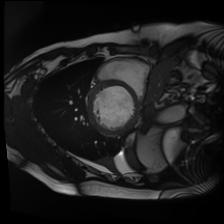

Groundtruth: 


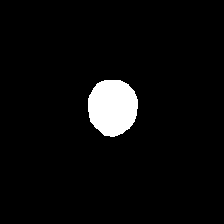

Model: unet


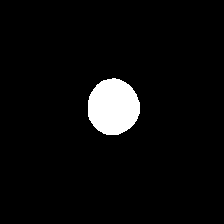

Evaluation Metrics:  {'acc': array(0.9973294, dtype=float32), 'sen': array(0.98235554, dtype=float32), 'pre': array(0.9595002, dtype=float32), 'rec': array(0.98235554, dtype=float32), 'dsc': array(0.97079337, dtype=float32), 'iou': array(0.9432444, dtype=float32)}
Model: upp


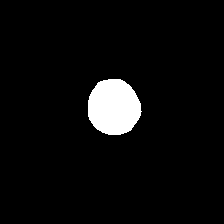

Evaluation Metrics:  {'acc': array(0.99637276, dtype=float32), 'sen': array(0.98412, dtype=float32), 'pre': array(0.93857807, dtype=float32), 'rec': array(0.98412, dtype=float32), 'dsc': array(0.96080965, dtype=float32), 'iou': array(0.9245752, dtype=float32)}
Model: fpn


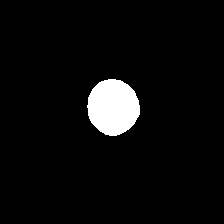

Evaluation Metrics:  {'acc': array(0.9979871, dtype=float32), 'sen': array(0.9885311, dtype=float32), 'pre': array(0.96761656, dtype=float32), 'rec': array(0.9885311, dtype=float32), 'dsc': array(0.977962, dtype=float32), 'iou': array(0.9568745, dtype=float32)}
Model: psp


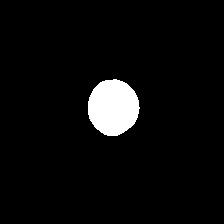

Evaluation Metrics:  {'acc': array(0.9982462, dtype=float32), 'sen': array(0.9845611, dtype=float32), 'pre': array(0.97680527, dtype=float32), 'rec': array(0.9845611, dtype=float32), 'dsc': array(0.9806678, dtype=float32), 'iou': array(0.962069, dtype=float32)}
Model: man


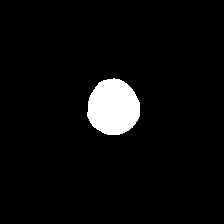

Evaluation Metrics:  {'acc': array(0.99665177, dtype=float32), 'sen': array(0.97882664, dtype=float32), 'pre': array(0.948696, dtype=float32), 'rec': array(0.97882664, dtype=float32), 'dsc': array(0.96352583, dtype=float32), 'iou': array(0.9296188, dtype=float32)}
Model: link


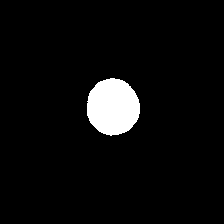

Evaluation Metrics:  {'acc': array(0.99669164, dtype=float32), 'sen': array(0.98985445, dtype=float32), 'pre': array(0.94009215, dtype=float32), 'rec': array(0.98985445, dtype=float32), 'dsc': array(0.96433175, dtype=float32), 'iou': array(0.93112034, dtype=float32)}


In [16]:
img_name = "patient001_3.png"
img_path = os.path.join(root_path, "Images", img_name)
map_path = os.path.join(root_path, "Masks", img_name)
img, map, _ = loader(img_path, map_path)
img, map = torch.tensor(img, dtype=torch.float32).to(device).unsqueeze(0), torch.tensor(map, dtype=torch.float32).to(device).unsqueeze(0)


print("Input Image: ")
disp_Tensor(img)
print("Groundtruth: ")
disp_Tensor(map)

img = img[:, :1, :, :]

for k in list(model_dict.keys()):
    model = get_model(model_dict[k]["model"])
    frame = MyFrame(model, 1, device, evalmode=True)
    frame.load(model_dict[k]["weights"])
    pred = frame.net(img)
    mets = metrics(pred, map)
    print("Model:", k)
    disp_Tensor(pred)
    print("Evaluation Metrics: ", mets)

Input Image: 


<ipython-input-4-909b5564497a>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-4-909b5564497a>:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


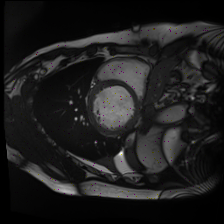

Groundtruth: 


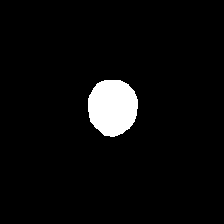

Model: unet


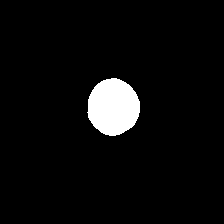

Evaluation Metrics:  {'acc': array(0.9974091, dtype=float32), 'sen': array(0.98985445, dtype=float32), 'pre': array(0.95448744, dtype=float32), 'rec': array(0.98985445, dtype=float32), 'dsc': array(0.97184926, dtype=float32), 'iou': array(0.9452401, dtype=float32)}
Model: upp


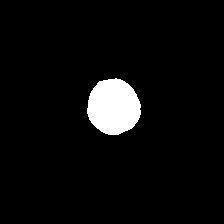

Evaluation Metrics:  {'acc': array(0.99629307, dtype=float32), 'sen': array(0.9805911, dtype=float32), 'pre': array(0.93995774, dtype=float32), 'rec': array(0.9805911, dtype=float32), 'dsc': array(0.9598446, dtype=float32), 'iou': array(0.9227895, dtype=float32)}
Model: fpn


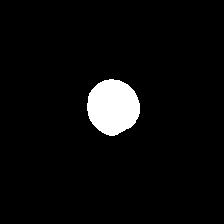

Evaluation Metrics:  {'acc': array(0.9973493, dtype=float32), 'sen': array(0.9783855, dtype=float32), 'pre': array(0.96351, dtype=float32), 'rec': array(0.9783855, dtype=float32), 'dsc': array(0.97089076, dtype=float32), 'iou': array(0.94342834, dtype=float32)}
Model: psp


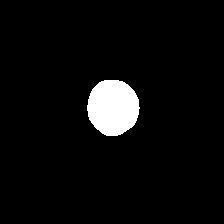

Evaluation Metrics:  {'acc': array(0.9982262, dtype=float32), 'sen': array(0.9925011, dtype=float32), 'pre': array(0.96899223, dtype=float32), 'rec': array(0.9925011, dtype=float32), 'dsc': array(0.9806058, dtype=float32), 'iou': array(0.9619495, dtype=float32)}
Model: man


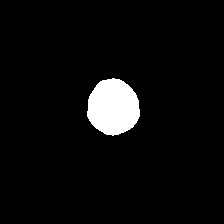

Evaluation Metrics:  {'acc': array(0.99691087, dtype=float32), 'sen': array(0.9814733, dtype=float32), 'pre': array(0.9516681, dtype=float32), 'rec': array(0.9814733, dtype=float32), 'dsc': array(0.96634096, dtype=float32), 'iou': array(0.93487394, dtype=float32)}
Model: link


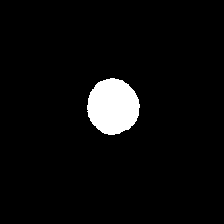

Evaluation Metrics:  {'acc': array(0.99722975, dtype=float32), 'sen': array(0.97794443, dtype=float32), 'pre': array(0.96140504, dtype=float32), 'rec': array(0.97794443, dtype=float32), 'dsc': array(0.9696042, dtype=float32), 'iou': array(0.9410017, dtype=float32)}


In [17]:
img_name = "patient001_3.png"
img_path = os.path.join(root_path, "Images", img_name)
map_path = os.path.join(root_path, "Masks", img_name)
img, map, _ = loader(img_path, map_path, noise="s&p", level=1)
img, map = torch.tensor(img, dtype=torch.float32).to(device).unsqueeze(0), torch.tensor(map, dtype=torch.float32).to(device).unsqueeze(0)


print("Input Image: ")
disp_Tensor(img)
print("Groundtruth: ")
disp_Tensor(map)

img = img[:, :1, :, :]

for k in list(model_dict.keys()):
    model = get_model(model_dict[k]["model"])
    frame = MyFrame(model, 1, device, evalmode=True)
    frame.load(model_dict[k]["weights"])
    pred = frame.net(img)
    mets = metrics(pred, map)
    print("Model:", k)
    disp_Tensor(pred)
    print("Evaluation Metrics: ", mets)

In [18]:
def calc_iou(pred, mask):
  pred = pred / np.amax(pred)
  TP = (mask * pred).sum()
  TN = ((1 - mask) * (1 - pred)).sum()
  FP = pred.sum() - TP
  FN = mask.sum() - TP

  iou = (TP)/(TP + FN + FP)

  return iou

In [21]:
iou_arr = [0] * 7

for pack in test_loader:
  #print(img)
  img = pack['img'].detach().cpu().numpy().squeeze()[:1,:,:]
  img = img/np.amax(img)
  img = img * 255.0
  #print(pack['map'].shape)
  label = pack['map'].detach().cpu().numpy().squeeze(0)[:1,:,:]

  th = threshold_isodata(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[0] += iou

  th = threshold_li(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[1] += iou

  th = threshold_mean(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[2] += iou

  th = threshold_minimum(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[3] += iou

  th = threshold_otsu(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[4] += iou

  th = threshold_triangle(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[5] += iou

  th = threshold_yen(img)
  bin = img > th
  iou = calc_iou(bin, label)
  iou_arr[6] += iou

iou_th = [x / 10. for x in iou_arr]
print(iou_th)

[0.3759119673078766, 0.321069312348634, 0.31490616864616544, 0.2320776872517422, 0.3768929413245082, 0.1708593918617332, 0.3677125995627586]


Image


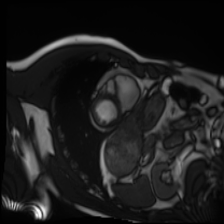

Label


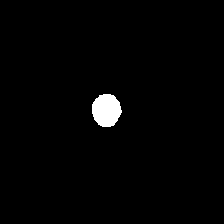

Isodata


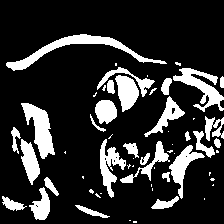

IoU:  1.0266797245963912
Li


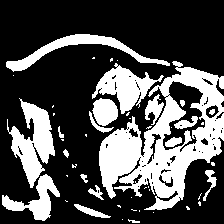

IoU:  1.9118234815805069
Mean


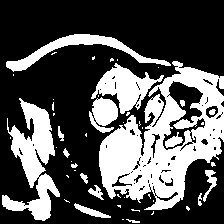

IoU:  2.240117130307467
Minimum


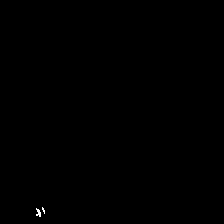

IoU:  0.0
Otsu


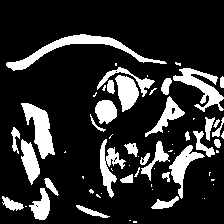

IoU:  0.9988961394185683
Triangle


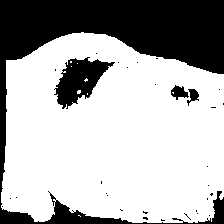

IoU:  5.680986406413385
Yen


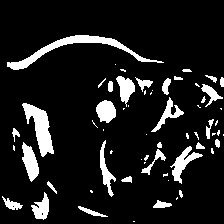

IoU:  0.7490093159065628
--------------------------------------------------


In [27]:
for i, pack in enumerate(test_loader):
  if i>0: continue
  img = pack['img'].detach().cpu().numpy().squeeze(0)[:1,:,:]
  img = img/np.amax(img)
  img = img * 255.
  label = pack['map'].detach().cpu().numpy().squeeze()*255

  print('Image')
  cv2_imshow(img[0])

  print('Label')
  cv2_imshow(label)

  print('Isodata')
  th = threshold_isodata(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Li')
  th = threshold_li(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Mean')
  th = threshold_mean(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Minimum')
  th = threshold_minimum(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Otsu')
  th = threshold_otsu(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Triangle')
  th = threshold_triangle(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('Yen')
  th = threshold_yen(img)
  bin = img > th
  cv2_imshow(bin[0]*255.)
  iou = calc_iou(bin, label)
  print('IoU: ', iou)

  print('-'*50)

In [ ]:
iou_arr = [0] * 2

for i, (img, label, name) in tqdm(enumerate(test_loader)):
  img = img.detach().cpu().numpy().squeeze()
  img = img/np.amax(img)
  label = label.detach().cpu().numpy().squeeze()[0, :, :]

  # fill regions to perform edge segmentation
  edges = canny(img)
  fill_im = nd.binary_fill_holes(edges)
  iou_arr[0] += calc_iou(fill_im, label)

  # Computing the Chan VESE segmentation technique
  chanvese = chan_vese(img, max_iter=1000, extended_output=True)[0]*1
  iou_arr[1] += calc_iou(chanvese, label)

iou_th = [x / 28. for x in iou_arr]
print(iou_th)

0it [00:00, ?it/s]<ipython-input-8-b9fa14eadb67>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(img_path).get_data()
<ipython-input-8-b9fa14eadb67>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nib.load(mask_path).get_data()
<ipython-input-23-744240cd789d>:14: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  chanvese = chan_vese(img, max_iter=10

[0.18631160232117705, 0.34364250542052943]


Image


<ipython-input-8-b9fa14eadb67>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img = nib.load(img_path).get_data()
<ipython-input-8-b9fa14eadb67>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask = nib.load(mask_path).get_data()


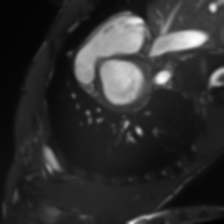

Region Filling


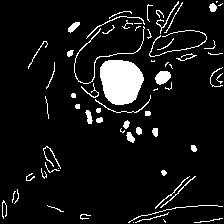

<ipython-input-24-1d83c0117b5d>:19: FutureWarning: `max_iter` is a deprecated argument name for `chan_vese`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  chanvese = chan_vese(img, max_iter=1000, extended_output=True)[0]*1


IoU:  0.24296607941099133
Chan VESE


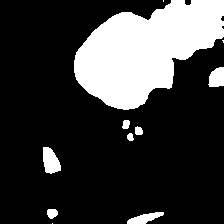

IoU:  0.45959375817278353
--------------------------------------------------


In [ ]:
for i, (img, label, name) in enumerate(test_loader):
  if i>0: continue
  img = img.detach().cpu().numpy().squeeze()
  img = img/np.amax(img)
  label = label.detach().cpu().numpy().squeeze()[0, :, :]

  print('Image')
  cv2_imshow(img*255.)

  # fill regions to perform edge segmentation
  print('Region Filling')
  edges = canny(img)
  fill_im = nd.binary_fill_holes(edges)
  cv2_imshow(fill_im*255.)
  print('IoU: ', calc_iou(fill_im, label))

  # Computing the Chan VESE segmentation technique
  print('Chan VESE')
  chanvese = chan_vese(img, max_iter=1000, extended_output=True)[0]*1
  cv2_imshow(chanvese*255.)
  print('IoU: ', calc_iou(chanvese, label))

  print('-'*50)

In [ ]:
for i, (img, label, name) in enumerate(test_loader):
  # if i>0: continue
  img = img.detach().cpu().numpy().squeeze()
  img = img/np.amax(img)
  label = label.detach().cpu().numpy().squeeze()[0, :, :]

  print('Image')
  cv2_imshow(img*255.)

  print('Gaussian')
  pil_img = Image.fromarray(img*255.)
  gauss = np.array(transforms.GaussianBlur(17).forward(pil_img))
  cv2_imshow(gauss)

  print('Salt & Pepper')
  sp = noisy("s&p", img)
  cv2_imshow(sp*255.)

  print('Speckle')
  sp = noisy("speckle", img)
  cv2_imshow(sp*255.)

  print('-'*50)

Output hidden; open in https://colab.research.google.com to view.